In [23]:
import os
import pandas as pd
import numpy as np

import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [24]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'


In [25]:
folders = ['./output_all', 'output_ExpandingWindowMA_pct', 'output_extra_currency', 'output_allindex+all_currency']

file_list = []
name_list = []
for folder in folders:
    for fn in os.listdir(folder):
        if not fn.startswith("pred___pp"):
            continue
        
        name = fn.replace("pred___", "")
        name = name.replace("___1981___2022___XAU_USD.csv", "")
        
        name = name.replace("XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX", 'all_index')
        name = name.replace("XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY", 'all_currency')
        
        file_list.append(os.path.join(folder, fn))
        name_list.append(name)
len(file_list)

167

In [26]:
len(name_list)

167

In [27]:
name_list

['pp10=xgbc((all_index)_(dd_vol))',
 'pp10=xgbc((all_index)_(dd_vol+TA))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel+excel_cross))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+dd_vol))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel))',
 'pp10=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))',
 'pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA)))',
 'pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
 'pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol)))',
 'pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA)))',
 'pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel)))',
 'pp10=xgbc((

In [28]:
def print_clustermap(data, title='', figsize=(12,12)):
    
    corr = data.corr()
    '''data_clean = data.applymap(lambda x: x if x!=0 else np.nan)
    for n in ['Growth','Mod','FICon','Con']:
        data_clean[n] = data_clean[n].fillna(0)
    corr = data_clean.corr()
    '''
    g = sns.clustermap(corr, method="complete", cmap='PuOr', annot=True, 
                   annot_kws={"size": 10}, vmin=-1, vmax=1, figsize=figsize)
    g.fig.suptitle(title)
    plt.show()

In [29]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()


In [30]:
def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se


In [31]:
def predict_freq(pred, freq='M'):
    
    #print(pred)
    #print(pred[pred.index.duplicated()])
    
    idx = pred.index.to_series()
    idx_m = idx.groupby(pd.Grouper(freq=freq)).first()
    pred_m = pred.groupby(pd.Grouper(freq=freq)).first()
    pred_m.index = idx_m
    
    #print(idx)
    #print(idx[idx.index.duplicated()])
    #print(pred_m)
    #print(pred_m[pred_m.index.duplicated()])
    
    pred_m = pred_m.dropna().reindex(idx).ffill()
    
    return pred_m


In [32]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d


In [33]:
"""def predict_cont_n(pred, n):
    
    pred_ewma = ewma(pred, 3)
    
    lb = 2**(-n)
    ub = 1-lb
    
    pred_cont_n = pred_ewma.apply(lambda x: s(x, lb, ub))
    
    pred_cont_n = pred_cont_n.ffill().fillna(1)
    
    return pred_cont_n
"""

'def predict_cont_n(pred, n):\n    \n    pred_ewma = ewma(pred, 3)\n    \n    lb = 2**(-n)\n    ub = 1-lb\n    \n    pred_cont_n = pred_ewma.apply(lambda x: s(x, lb, ub))\n    \n    pred_cont_n = pred_cont_n.ffill().fillna(1)\n    \n    return pred_cont_n\n'

In [34]:
def exp_sum(se):
    _sum = 0
    for i,v in enumerate(se):
        _sum += v*(2**i)
    return _sum
def cont_n_01(x, n):
    if x <= 0:
        return 0
    if x >= 2**n - 1:
        return 1
    return np.nan
def predict_cont_n(vote, n, rb_lookback=True):
    if not rb_lookback:
        v_tmp = vote.groupby(pd.Grouper(freq='M')).apply(lambda x: predict_cont_n(x, n)).values
        return pd.Series(v_tmp, index=vote.index)
    vres = vote.rolling(n).apply(lambda x: exp_sum(x))
    vote_c = vres.apply(lambda x: cont_n_01(x, n))
    if np.isnan(vote_c.iloc[0]):
        vote_c.iloc[0] = vote.iloc[0]
    vote_c = vote_c.ffill()
    return vote_c

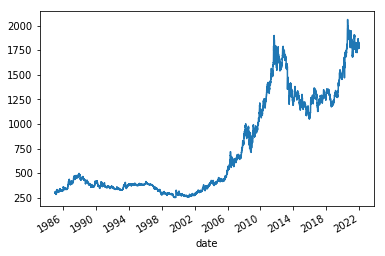

In [35]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)
price[start:end].plot()

In [36]:
true_ret = price.pct_change()
true_ret = true_ret[start:end]
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [37]:
true_up = (true_ret>=0)
true_up

date
1985-01-02    False
1985-01-03    False
1985-01-04     True
1985-01-07    False
1985-01-08     True
              ...  
2021-12-27     True
2021-12-28    False
2021-12-29    False
2021-12-30     True
2021-12-31     True
Name: adj_close, Length: 9612, dtype: bool

In [38]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


In [39]:
def ret_short_once_every_interval(ret, shorting_interval):
    
    ret_short = ret.copy()
    
    t_prev = ret.index[0]
    cum_prod_prev = 1
    t_start_short = ret.index[0]
    cum_prod = 1
    
    for t in ret.index[1:]:
        if shorting_interval[t]:
            if not shorting_interval[t_prev]:
                t_start_short = t
                
            cum_prod = 2 - (1+ret[t_start_short:t]).prod()
            if cum_prod <= 0:
                ret_short[t:] = 0
                ret_short[t] = -1
                
                print('t_start_short', t_start_short)
                print('price', price[t_start_short])
                print('t', t)
                print('price', price[t])
                
                print('broke on', t)
                
                break
            ret_short[t] = cum_prod / cum_prod_prev - 1
                
                
        else:
            cum_prod = 1
        
        t_prev = t
        cum_prod_prev = cum_prod
    
    return ret_short
    

In [40]:
true_ret

date
1985-01-02   -0.009082
1985-01-03   -0.010475
1985-01-04    0.002646
1985-01-07   -0.016166
1985-01-08    0.012743
                ...   
2021-12-27    0.001543
2021-12-28   -0.003054
2021-12-29   -0.000947
2021-12-30    0.006293
2021-12-31    0.007372
Name: adj_close, Length: 9612, dtype: float64

In [171]:
'''highlight = price.index[fast_indicator>slow_indicator]
shorting_interval = pd.Series(ret.index.isin(highlight), ret.index)
shorting_interval'''

'highlight = price.index[fast_indicator>slow_indicator]\nshorting_interval = pd.Series(ret.index.isin(highlight), ret.index)\nshorting_interval'

In [172]:
'''shorting_interval[~shorting_interval]'''

'shorting_interval[~shorting_interval]'

In [173]:
'''ret_short_once = ret_short_once_every_interval(ret, shorting_interval)
ret_short_once'''

'ret_short_once = ret_short_once_every_interval(ret, shorting_interval)\nret_short_once'

In [41]:
def sim_indicator(pred_up, name, plot=False):
    
    pred_up = pred_up.reindex(true_ret.index).ffill()
    
    indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = true_ret.copy()
    ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    
    other_met = other_metric(ret_df)
    
    """
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        #other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, pred_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, pred_up)]
        
    """
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [42]:
def sim_indicator_prob(prob_up, name, plot=False):
    
    #indicator = pred_up[pred_up==1].index
    
    
    ret_df = pd.DataFrame()

    #ret_df['buy_and_hold'] = ret[start:]

    ret_i = ret[start:end].copy()
    #ret_i.loc[~ret_i.index.isin(indicator)] = 0
    ret_df['hold_only_pred_up_{}'.format(name)] = ret_i*prob_up[start:end]
    
    #highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    
    highlight_ratio = prob_up.mean()
    #flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    flip_ratio = (prob_up - prob_up.shift()).abs().mean()
    
    
    
    #print('highlight_ratio', highlight_ratio)
    #print('flip_ratio', flip_ratio)
    
    
    empy_met = empy_metric(ret_df)
    
    pred_up = prob_up.apply(lambda x: 0 if x<0.5 else 1)
    
    
    true_up = (ret[start:]>=0).dropna()
    idx_tmp = pred_up.index & true_up.index
    true_up = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    prob_up = prob_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up, pred_up)
    prec = precision_score(true_up, pred_up)
    '''
    true_up21 = (price.shift(-20) - price.shift(1))>=0
    true_up21 = true_up21.reindex(idx_tmp) * 1
    accu21 = accuracy_score(true_up21, pred_up)
    '''
    
    true_up_pct = ret.reindex(idx_tmp)
    #true_up_pct_scaled = (true_up_pct-true_up_pct.min())/(true_up_pct.max()-true_up_pct.min())
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    expvar = explained_variance_score(true_up_pct_scaled, prob_up)
    mse = mean_squared_error(true_up_pct_scaled, prob_up)
    
    
    other_met = pd.DataFrame()
    other_met['highlight_ratio'] = [highlight_ratio]
    other_met['flip_ratio'] = [flip_ratio]
    other_met['accu'] = [accu]
    other_met['prec'] = [prec]
    other_met['expvar'] = [expvar]
    other_met['mse'] = [mse]
    
    
    #other_met['accu21'] = [accu21]
    
    for k in [5,10,21]:
        pct_change = (price.shift(1-k) - price.shift(1))/price.shift(1)
        pct_change = pct_change.reindex(idx_tmp)
        true_up_k = (pct_change>=0)*1
        other_met['accu{}'.format(k)] = [accuracy_score(true_up_k, pred_up)]
        other_met['prec{}'.format(k)] = [precision_score(true_up_k, pred_up)]
        
        #true_up_pct_scaled = (pct_change-pct_change.min())/(pct_change.max()-pct_change.min())
        true_up_pct_scaled = pct_change/pct_change.std() + 0.5
        other_met['expvar{}'.format(k)] = [explained_variance_score(true_up_pct_scaled, prob_up)]
        other_met['mse{}'.format(k)] = [mean_squared_error(true_up_pct_scaled, prob_up)]
        
    
    
    
    
    
    #other_met['accu'] = [accu]
    #other_met['accu21'] = [accu21]
    
    #display(empy_met)
    
    if plot:
        fig, ax = plt.subplots()
        (1+ret_df).cumprod().plot(ax=ax)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_yscale("log")
        plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    res['other_metric'] = other_met
    
    return res
    

In [176]:
"""def sim_fast_slow_indicator(fast_indicator, slow_indicator, indicator_name_list):

    tempdf = pd.concat([fast_indicator, slow_indicator], 1, keys=indicator_name_list)
    
    
    #fig, axs = plt.subplots(2, figsize=(12,12))
    #tempdf.plot(ax=axs[0])
    #axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    highlight = price[start:].index[fast_indicator>slow_indicator]
    highlight_str = '{}>{}'.format(
        indicator_name_list[0],
        indicator_name_list[1])
    non_highlight_str = '{}<{}'.format(
        indicator_name_list[0],
        indicator_name_list[1])
    
    
    
    ret_df = pd.DataFrame()

    ret_df['buy_and_hold_{}_{}'.format(*indicator_name_list)] = ret[start:]

    ret_i = ret[start:].copy()
    ret_i.loc[~ret_i.index.isin(highlight)] = 0
    ret_df['hold_only_{}'.format(highlight_str)] = ret_i
    
    '''
    ret_j = ret[start:].copy()
    ret_j.loc[ret_j.index.isin(highlight)] = 0
    ret_df['hold_only_{}'.format(non_highlight_str)] = ret_j
    '''
    
    
    '''
    ret_k = ret[start:].copy()
    ret_k.loc[~ret_k.index.isin(highlight)] = -ret_k.loc[~ret_k.index.isin(highlight)]
    ret_df['long_highlight__short_daily_non_highlight'] = ret_k
    
    ret_df['short_daily_highlight__long_non_highlight'] = -ret_k
    
    
    ret_s = ret[start:].copy()
    shorting_interval = ~ret.index.isin(highlight)
    shorting_interval_seri = pd.Series(shorting_interval, ret.index)
    ret_short = ret_short_once_every_interval(ret_s, shorting_interval_seri)
    ret_df['long_highlight__short_non_highlight'] = ret_short
    
    
    ret_s = ret[start:].copy()
    shorting_interval = ret.index.isin(highlight)
    shorting_interval_seri = pd.Series(shorting_interval, ret.index)
    ret_short = ret_short_once_every_interval(ret_s, shorting_interval_seri)
    ret_df['short_highlight__long_non_highlight'] = ret_short
    
    '''
    
    
    #(1+ret_df).cumprod().plot(ax=axs[1])
    #axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #axs[1].set_yscale("log")
    
    highlight_ratio = ret_i.apply(lambda x: 1 if x!=0 else 0).mean()
    print('pred_up_ratio', highlight_ratio)
    empy_met = empy_metric(ret_df)
    display(empy_met)
    
    #plt.show()
    
    res = {}
    res['ret_df'] = ret_df
    res['empy_metric'] = empy_met
    
    return res"""

'def sim_fast_slow_indicator(fast_indicator, slow_indicator, indicator_name_list):\n\n    tempdf = pd.concat([fast_indicator, slow_indicator], 1, keys=indicator_name_list)\n    \n    \n    #fig, axs = plt.subplots(2, figsize=(12,12))\n    #tempdf.plot(ax=axs[0])\n    #axs[0].legend(loc=\'center left\', bbox_to_anchor=(1, 0.5))\n    \n    \n    highlight = price[start:].index[fast_indicator>slow_indicator]\n    highlight_str = \'{}>{}\'.format(\n        indicator_name_list[0],\n        indicator_name_list[1])\n    non_highlight_str = \'{}<{}\'.format(\n        indicator_name_list[0],\n        indicator_name_list[1])\n    \n    \n    \n    ret_df = pd.DataFrame()\n\n    ret_df[\'buy_and_hold_{}_{}\'.format(*indicator_name_list)] = ret[start:]\n\n    ret_i = ret[start:].copy()\n    ret_i.loc[~ret_i.index.isin(highlight)] = 0\n    ret_df[\'hold_only_{}\'.format(highlight_str)] = ret_i\n    \n    \'\'\'\n    ret_j = ret[start:].copy()\n    ret_j.loc[ret_j.index.isin(highlight)] = 0\n    ret

In [177]:
'''ld = [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 288]
lm = [l*21 for l in ld]
ll = ld+lm
ll.sort()
ll = [l for l in ll if l<1000]
'''

'ld = [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 288]\nlm = [l*21 for l in ld]\nll = ld+lm\nll.sort()\nll = [l for l in ll if l<1000]\n'

In [178]:
#ll = [1, 2, 5, 8]

In [43]:
pred_all = pd.DataFrame()
result_all = {}

for name, csv in zip(name_list, file_list):
    
    #display(name)
    try:
        pred_df = pd.read_csv(csv.format(csv), index_col=0)
    except:
        print('no file [{}]'.format(csv))
        continue
    
    pred_df.index = pd.to_datetime(pred_df.index)
    
    pred_up = pred_df['y_pred']
    prob_up = pred_df['y_prob']
    
    
    
    
    
    #print('flip_ratio', (pred_up - pred_up.shift()).abs().mean())
    
    #indicator = pred_up[pred_up==1].index
    
    
    pred_all[name] = pred_up
    result_all[name] = sim_indicator(pred_up, name)
    
    
    """
    for f in ['5D', '10D', '21D', 'W', '2W', 'M']:
        name_f = name+'_freq_'+f
        pred_all[name_f] = predict_freq(pred_up, freq=f)
        result_all[name_f] = sim_indicator(pred_all[name_f], name_f)
        
    
    #for n in [2,3,4,5]:
    for n in range(2,22):
        name_c = name+'_cont_'+str(n)+'_rb_lookback'
        pred_all[name_c] = predict_cont_n(pred_up, n, rb_lookback=True)
        result_all[name_c] = sim_indicator(pred_all[name_c], name_c)
        
        name_c = name+'_cont_'+str(n)+'_rb_follow'
        pred_all[name_c] = predict_cont_n(pred_up, n, rb_lookback=False)
        result_all[name_c] = sim_indicator(pred_all[name_c], name_c)
        
    """
        
        
    '''
    prob_all[name] = prob_up
    
    name_prob = name+'_prob'
    
    result_all[name_prob] = sim_indicator_prob(prob_up, name_prob)
    
    for f in ['5D', '10D', '21D', 'W', '2W', 'M']:
        name_f = name_prob+'_freq_'+f
        prob_all[name_f] = predict_freq(prob_up, freq=f)
        result_all[name_f] = sim_indicator_prob(prob_all[name_f], name_f)
        
    
    for n in [1,2,3,4,5]:
        name_c = name_prob+'_cont_'+str(n)
        prob_all[name_c] = predict_cont_n(prob_up, n)
        result_all[name_c] = sim_indicator_prob(prob_all[name_c], name_c)
    
    '''
pred_all['buy_and_hold'] = 1

In [180]:
"""name = 'ema_all_1_34_return___cross_ema_all_1_34_price___5D___vote_a'

vote_list = [
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set1',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set2',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set3',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set4',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set5',
]

pred_up = pd.concat([pred_all[n] for n in vote_list], 1).mean(1).apply(lambda x: s(x, 0.5, 0.5))
pred_all[name] = pred_up
result_all[name] = sim_indicator(pred_up, name)
    
for f in ['10D', '21D', 'M']:
    name_f = name+'_freq_'+f
    pred_all[name_f] = predict_freq(pred_up, freq=f)
    result_all[name_f] = sim_indicator(pred_all[name_f], name_f)
        
for n in [2,3,4,5]:
    name_c = name+'_cont_'+str(n)
    pred_all[name_c] = predict_cont_n(pred_up, n)
    result_all[name_c] = sim_indicator(pred_all[name_c], name_c)
        """

"name = 'ema_all_1_34_return___cross_ema_all_1_34_price___5D___vote_a'\n\nvote_list = [\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set1',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set2',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set3',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set4',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___set5',\n]\n\npred_up = pd.concat([pred_all[n] for n in vote_list], 1).mean(1).apply(lambda x: s(x, 0.5, 0.5))\npred_all[name] = pred_up\nresult_all[name] = sim_indicator(pred_up, name)\n    \nfor f in ['10D', '21D', 'M']:\n    name_f = name+'_freq_'+f\n    pred_all[name_f] = predict_freq(pred_up, freq=f)\n    result_all[name_f] = sim_indicator(pred_all[name_f], name_f)\n        \nfor n in [2,3,4,5]:\n    name_c = name+'_cont_'+str(n)\n    pred_all[name_c] = predict_cont_n(pred_up, n)\n    result_all[name_c] = sim_indicator(pred_all[name_c], name_c)\n        "

In [181]:
"""name = 'ema_all_1_34_return___cross_ema_all_1_34_price___5D___vote_b'

vote_list = [
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff1',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff2',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff3',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff4',
    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff5',
]

pred_up = pd.concat([pred_all[n] for n in vote_list], 1).mean(1).apply(lambda x: s(x, 0.5, 0.5))
pred_all[name] = pred_up
result_all[name] = sim_indicator(pred_up, name)
    
for f in ['10D', '21D', 'M']:
    name_f = name+'_freq_'+f
    pred_all[name_f] = predict_freq(pred_up, freq=f)
    result_all[name_f] = sim_indicator(pred_all[name_f], name_f)
        
for n in [2,3,4,5]:
    name_c = name+'_cont_'+str(n)
    pred_all[name_c] = predict_cont_n(pred_up, n)
    result_all[name_c] = sim_indicator(pred_all[name_c], name_c)
        """

"name = 'ema_all_1_34_return___cross_ema_all_1_34_price___5D___vote_b'\n\nvote_list = [\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff1',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff2',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff3',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff4',\n    'ema_all_1_34_return___cross_ema_all_1_34_price___5D___fff5',\n]\n\npred_up = pd.concat([pred_all[n] for n in vote_list], 1).mean(1).apply(lambda x: s(x, 0.5, 0.5))\npred_all[name] = pred_up\nresult_all[name] = sim_indicator(pred_up, name)\n    \nfor f in ['10D', '21D', 'M']:\n    name_f = name+'_freq_'+f\n    pred_all[name_f] = predict_freq(pred_up, freq=f)\n    result_all[name_f] = sim_indicator(pred_all[name_f], name_f)\n        \nfor n in [2,3,4,5]:\n    name_c = name+'_cont_'+str(n)\n    pred_all[name_c] = predict_cont_n(pred_up, n)\n    result_all[name_c] = sim_indicator(pred_all[name_c], name_c)\n        "

In [22]:
pred_all.to_csv('output_others/xgb_XAUUSD.csv')

In [47]:
name_list = []
se_list = []
name_list.append('buy_and_hold')
se_list.append(empy_metric(true_ret))

for name, r in result_all.items():
    #print(name)
    #print(r['empy_metric'])
    #empy_metric_all[name] = r['empy_metric'].iloc[0]
    name_list.append(name)
    se_list.append(r['empy_metric'].iloc[0])

    
empy_metric_all = pd.concat(se_list, 1, keys=name_list).T
empy_metric_all_good_sharpe = empy_metric_all.sort_values('sharpe_ratio').loc['buy_and_hold':]
display(empy_metric_all_good_sharpe)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
pp21=xgbc((all_index+all_currency)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position)),2.760795,0.035338,0.378096,0.107013,-0.476673,-0.175186,0.074135,0.201718
pp5=xgbc((all_index+all_currency)_(price_position)),2.524859,0.033581,0.384856,0.098428,-0.321522,-0.086956,0.104444,0.386185
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA))),3.242497,0.038615,0.387134,0.114887,-0.406742,-0.126521,0.094937,0.305205
pp21=xgbc(EMA_return_all_1_34),2.749644,0.035258,0.388480,0.102811,-0.321897,-0.113746,0.109531,0.309969
pp21=xgbc((all_currency)_(EMA_return_all_1_34)),2.909480,0.036391,0.393282,0.104893,-0.323988,-0.115241,0.112323,0.315783
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA))),2.958765,0.036732,0.403364,0.102415,-0.294900,-0.112953,0.124556,0.325195
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel))),2.961915,0.036753,0.404403,0.102111,-0.308131,-0.106429,0.119278,0.345331
pp10=xgbc((all_index+all_currency)_(price_position)),3.009714,0.037079,0.405944,0.102664,-0.409014,-0.119968,0.090655,0.309076
pp5=xgbc((all_index+all_currency)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position)),3.265715,0.038763,0.410243,0.106547,-0.309422,-0.123727,0.125277,0.313298


In [48]:
name_list = []
se_list = []

for name, r in result_all.items():
    #print(name)
    #print(r['empy_metric'])
    #empy_metric_all[name] = r['empy_metric'].iloc[0]
    name_list.append(name)
    se_list.append(r['other_metric'].iloc[0])

    
other_metric_all = pd.concat(se_list, 1, keys=name_list).T

other_metric_all.loc['buy_and_hold'] = 0

display(other_metric_all)

,highlight_ratio,flip_ratio,accu,prec,mse
pp10=xgbc((all_index)_(dd_vol)),0.454952,0.078036,0.492093,0.509947,1.254052
pp10=xgbc((all_index)_(dd_vol+TA)),0.487308,0.150453,0.498856,0.516225,1.258403
pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA)),0.490012,0.142649,0.496567,0.513800,1.259054
pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.484603,0.140776,0.499272,0.516745,1.248992
pp10=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel+excel_cross)),0.487099,0.137655,0.491365,0.508543,1.250091
...,...,...,...,...,...
pp5=xgbc((all_index+all_currency)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position)),0.486475,0.155967,0.501561,0.519033,1.238839
pp5=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.485643,0.123088,0.501352,0.518852,1.244743
pp5=xgbc((all_index+all_currency)_(price_position)),0.432688,0.237020,0.508115,0.528973,1.243566
pp5=xgbc((all_index+all_currency)_(TA)),0.494902,0.154719,0.496255,0.513349,1.263447


In [46]:
ret_all = pd.DataFrame()
ret_all['buy_and_hold'] = true_ret


for name, r in result_all.items():
    #print(name)
    #print(r['empy_metric'])
    ret_all[name] = r['ret_df'].iloc[:,0]

    
    
"""
fig, ax = plt.subplots(figsize=(12,6))
(1+ret_all).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

'\nfig, ax = plt.subplots(figsize=(12,6))\n(1+ret_all).cumprod().plot(ax=ax)\nax.legend(loc=\'center left\', bbox_to_anchor=(1, 0.5))\nax.set_yscale("log")\n'

In [33]:
'''preds_summary = pd.read_csv('preds_summary.csv', index_col=0)
preds_summary'''

"preds_summary = pd.read_csv('preds_summary.csv', index_col=0)\npreds_summary"

In [34]:
'''(preds_summary - preds_summary.shift()).abs().mean().sort_values().plot()'''

'(preds_summary - preds_summary.shift()).abs().mean().sort_values().plot()'

In [35]:
'''

for name in preds_summary.columns:
    
    display(name)
    
    pred_up = preds_summary[name]
    pred_up.index = pd.to_datetime(pred_up.index)
    
    print('flip ratio', (pred_up - pred_up.shift()).abs().mean())
    
    # indicator = pred_up[pred_up==1].index
    
    res = sim_indicator(pred_up, name)
    result_all[name] = res'''

"\n\nfor name in preds_summary.columns:\n    \n    display(name)\n    \n    pred_up = preds_summary[name]\n    pred_up.index = pd.to_datetime(pred_up.index)\n    \n    print('flip ratio', (pred_up - pred_up.shift()).abs().mean())\n    \n    # indicator = pred_up[pred_up==1].index\n    \n    res = sim_indicator(pred_up, name)\n    result_all[name] = res"

In [36]:
'''result_all = {}


for fast in ll:
    for slow in ll:
        if slow > fast:
                fast_indicator = ewma(price.shift(), fast)[start:]
                slow_indicator = ewma(price.shift(), slow)[start:]
                indicator_name_list = ['EMA{}'.format(fast), 'EMA{}'.format(slow)]
                res = sim_fast_slow_indicator(fast_indicator, slow_indicator, indicator_name_list)
                result_all['EMA_{}_{}'.format(fast, slow)] = res'''

"result_all = {}\n\n\nfor fast in ll:\n    for slow in ll:\n        if slow > fast:\n                fast_indicator = ewma(price.shift(), fast)[start:]\n                slow_indicator = ewma(price.shift(), slow)[start:]\n                indicator_name_list = ['EMA{}'.format(fast), 'EMA{}'.format(slow)]\n                res = sim_fast_slow_indicator(fast_indicator, slow_indicator, indicator_name_list)\n                result_all['EMA_{}_{}'.format(fast, slow)] = res"

In [36]:
pred_3ema = pd.read_csv('output_all/pred_3ema.csv', index_col=0)
pred_3ema.index = pd.to_datetime(pred_3ema.index)
pred_3ema = pred_3ema[start:end]
pred_3ema

,cross_3ema
Date,
1985-01-02,0
1985-01-03,0
1985-01-04,0
1985-01-07,0
1985-01-08,0
...,...
2021-12-27,1
2021-12-28,1
2021-12-29,1


In [38]:
# try rolling

In [39]:
#met_y = ret_all.groupby(pd.Grouper(freq='A')).apply(lambda x: empy_metric(x)['return/avgdd']).shift()
#met_y

In [40]:
#met_y.max(1)

In [41]:
# pred_all

In [42]:
#for y, score in met_y.T.items():
#    print(y)
#    print(score)

In [31]:
#vote_se = pd.Series(1, ret_all.index)

lookback_list = ['10A', '5A', '3A', 'A', 'M']
roll_list = ['A', 'A', 'A', 'A', 'M']
top_n_list = [4,6,10,20,30,60,90]

# lookback_list = ['5A', 'A']
# roll_list = ['A', 'A']
# top_n_list = [10,20]


#top_n_name_list = ['vote_c3ema_roll_top{}'.format(n) for n in top_n_list]
#top_n_name_list = []

topn_dict = {}

# pred_sub = pd.DataFrame(1, ret_all.index, ['c3ema'])
# pred_sub['c3ema'] = pred_3ema
pred_sub = pd.DataFrame(index=ret_all.index)
proba_sub = pd.DataFrame(index=ret_all.index)

chosen_df = {}
# for l in lookback_list:
#     for n in top_n_list:
#         chosen_df[(l, n)] = pd.DataFrame()

for l,f in zip(lookback_list, roll_list):
    
    met_y = ret_all.groupby(pd.Grouper(freq=f)).apply(lambda x: empy_metric(x)['return/avgdd']).shift()
    #display(met_y)
    
    r_str = l.replace(f,'')
    r_str = r_str if r_str else 1
    
    met_y = met_y.rolling(int(r_str)).sum()
    #display(met_y)
    
    for y, score in met_y.T.items():
        y_str = str(y)[:4] if 'A' in f else str(y)[:7]
        #print(y_str)
        top_idx_all = score.nlargest(max(top_n_list)).index
        
        for n in top_n_list:
            top_n_name = 'vote_lookback{}_roll{}_top{}'.format(l, f, n)
            
            
            
            #top_idx = score.nlargest(n).index
            top_idx = top_idx_all[:n]
#             topn_dict[top_n_name] = top_idx
            if top_n_name not in chosen_df.keys():
                chosen_df[top_n_name] = pd.DataFrame()
            chosen_df[top_n_name].loc[y_str, top_idx] = 1
            
            
#             vote_df_tmp = pd.concat([pred_3ema[y_str]]+[pred_all[x][y_str] for x in top_idx], 1)

            # vote without c3ema
            vote_df_tmp = pred_all[top_idx].mean(1)
            proba_sub.loc[y_str, top_n_name] = vote_df_tmp.copy()
            vote_tmp = vote_df_tmp.apply(lambda x: 0 if x<0.5 else 1)
            pred_sub.loc[y_str, top_n_name] = vote_tmp

    
# for f in roll_list:
#     for n in top_n_list:
#         chosen_df[(f, n)] = chosen_df[(f, n)].fillna(0)

for n, top_l in chosen_df.items():
    chosen_df[n] = top_l.fillna(0)
    
#vote_se
#display(pred_sub)
#display(chosen_df)


vote_lookback10A_rollA_top4


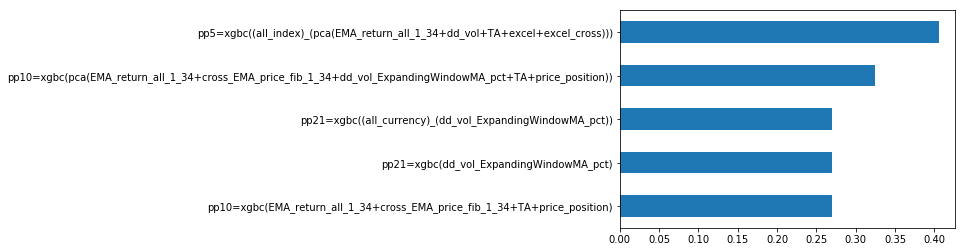

vote_lookback10A_rollA_top6


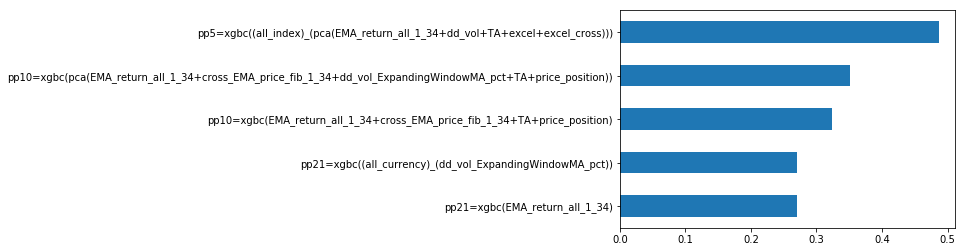

vote_lookback10A_rollA_top10


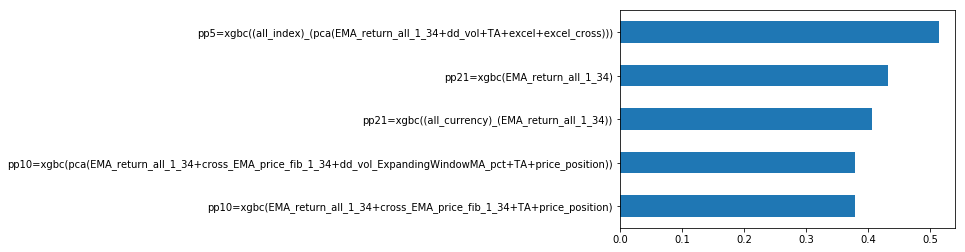

vote_lookback10A_rollA_top20


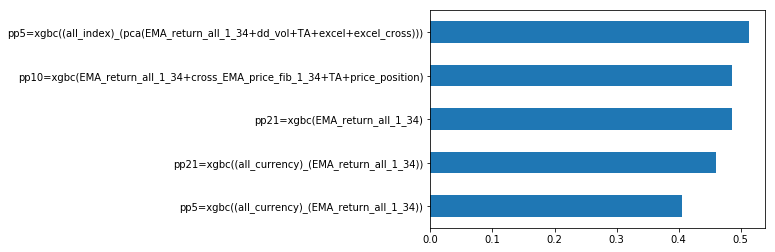

vote_lookback10A_rollA_top30


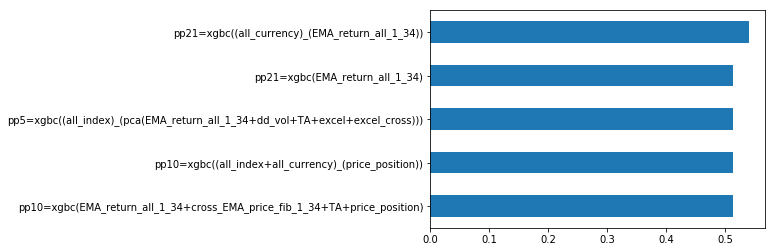

vote_lookback10A_rollA_top60


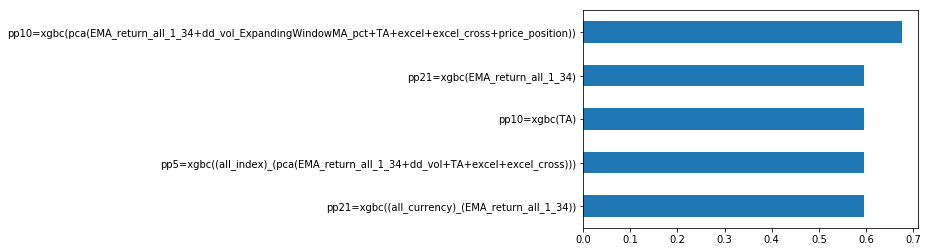

vote_lookback10A_rollA_top90


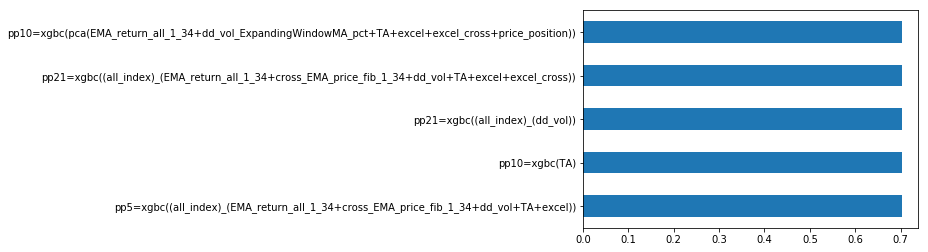

vote_lookback5A_rollA_top4


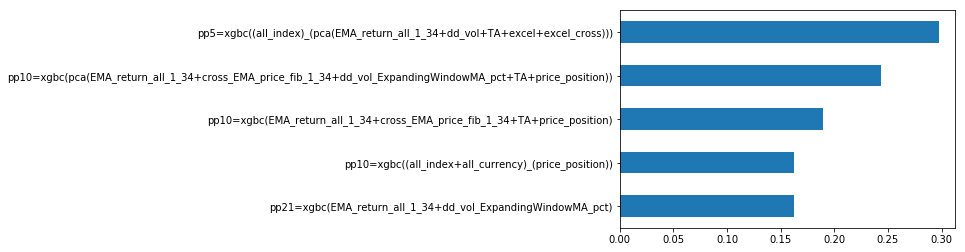

vote_lookback5A_rollA_top6


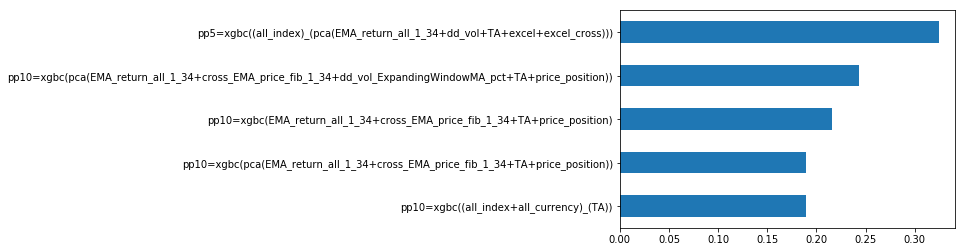

vote_lookback5A_rollA_top10


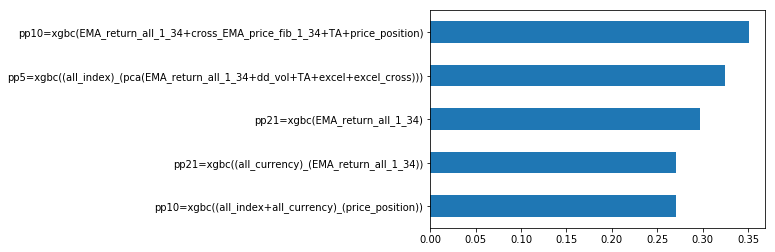

vote_lookback5A_rollA_top20


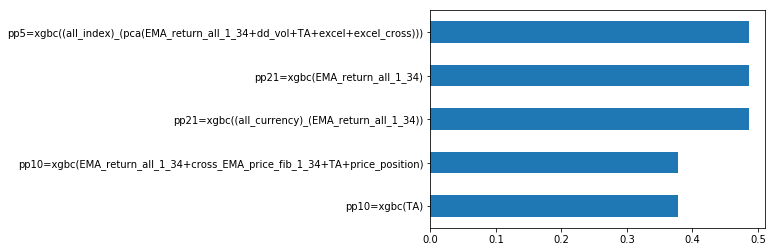

vote_lookback5A_rollA_top30


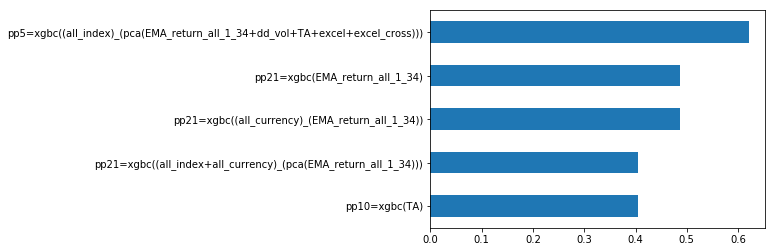

vote_lookback5A_rollA_top60


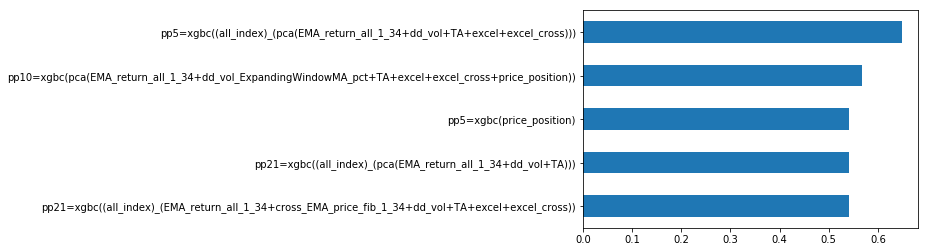

vote_lookback5A_rollA_top90


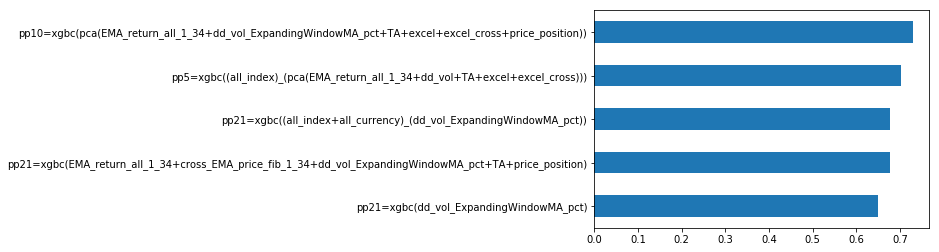

vote_lookback3A_rollA_top4


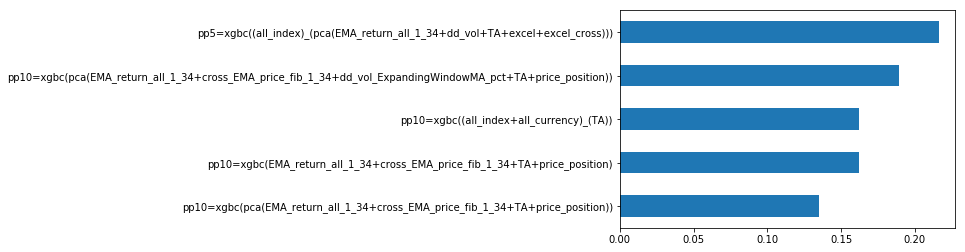

vote_lookback3A_rollA_top6


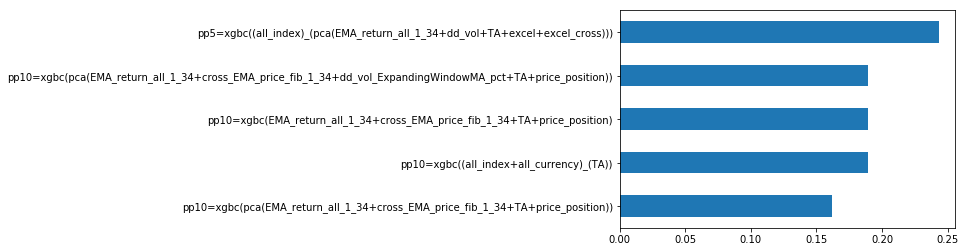

vote_lookback3A_rollA_top10


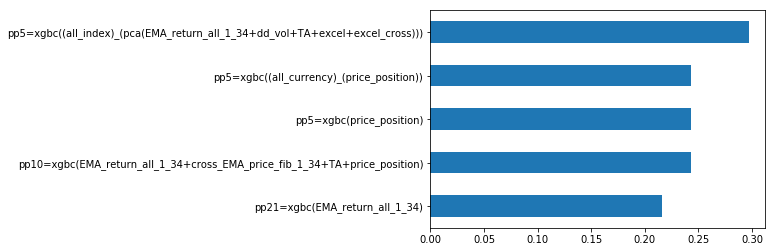

vote_lookback3A_rollA_top20


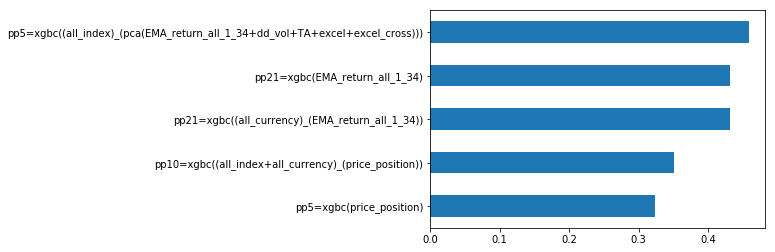

vote_lookback3A_rollA_top30


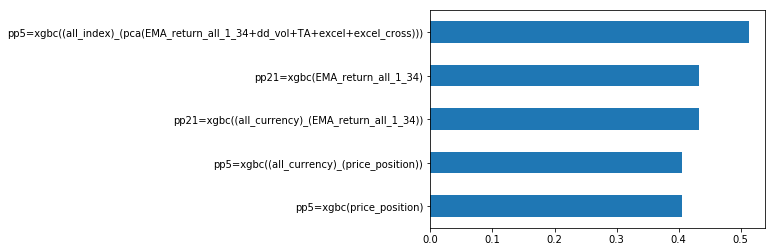

vote_lookback3A_rollA_top60


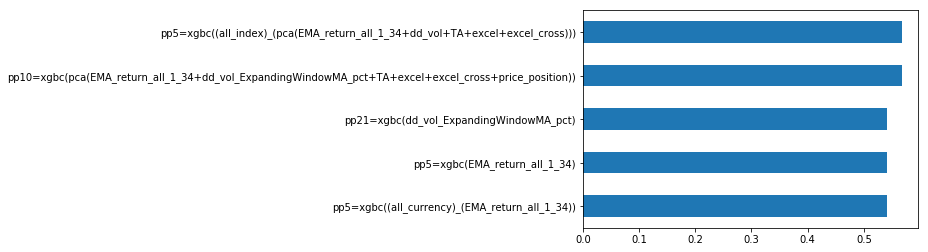

vote_lookback3A_rollA_top90


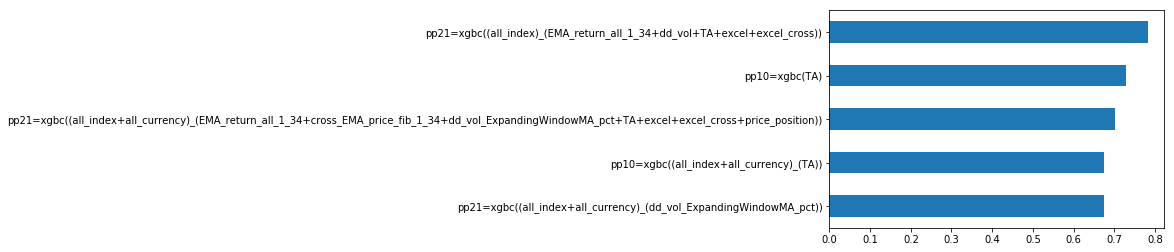

vote_lookbackA_rollA_top4


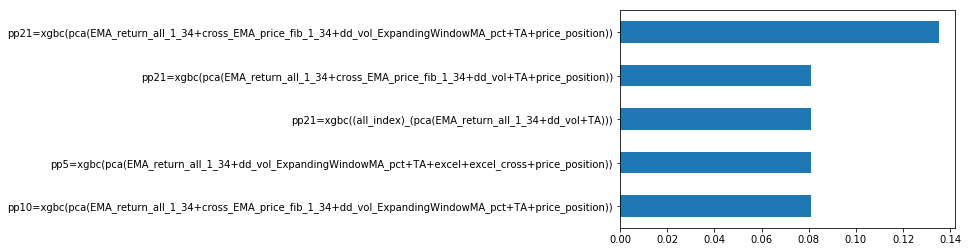

vote_lookbackA_rollA_top6


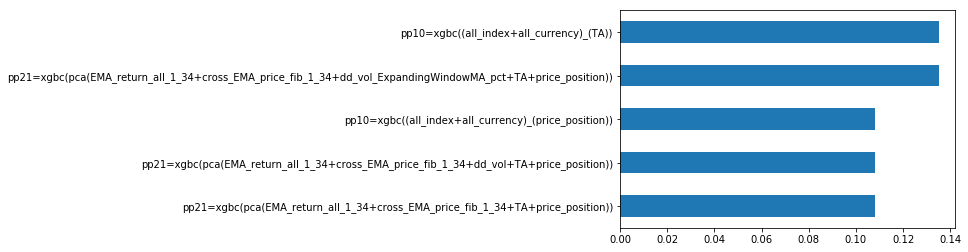

vote_lookbackA_rollA_top10


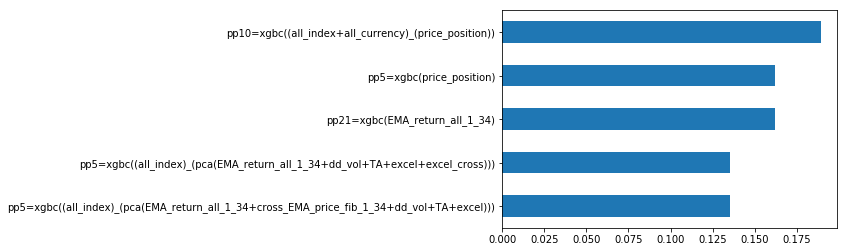

vote_lookbackA_rollA_top20


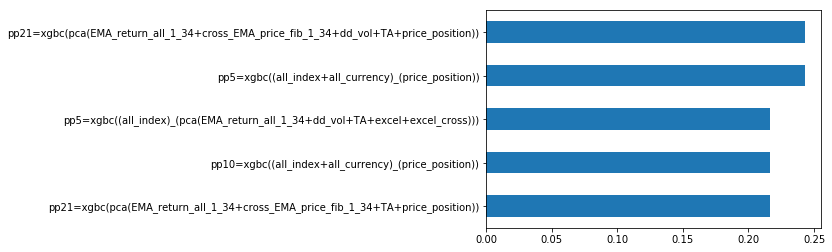

vote_lookbackA_rollA_top30


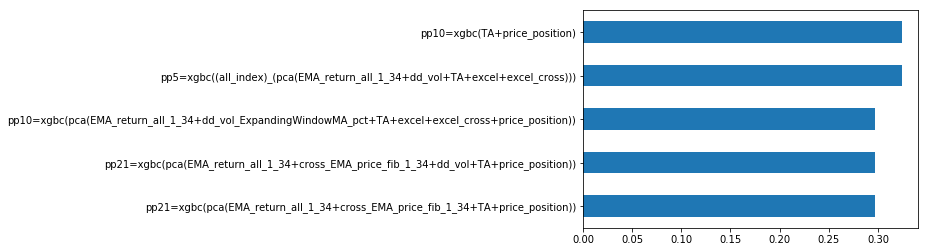

vote_lookbackA_rollA_top60


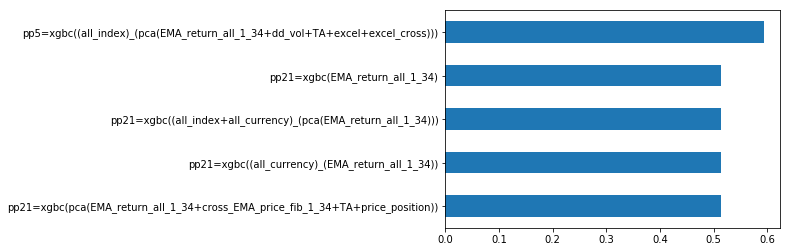

vote_lookbackA_rollA_top90


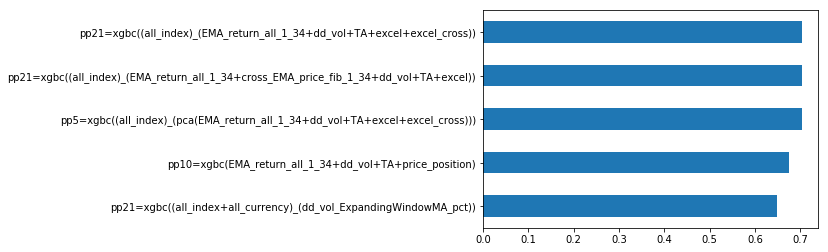

vote_lookbackM_rollM_top4


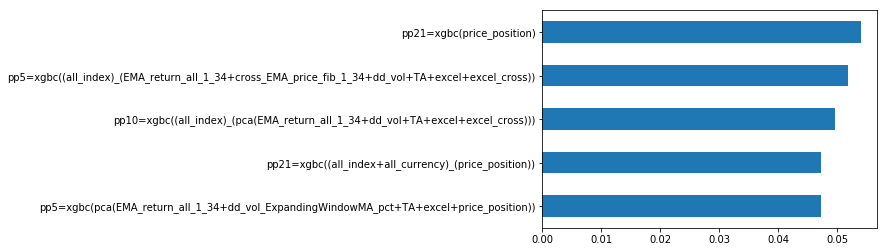

vote_lookbackM_rollM_top6


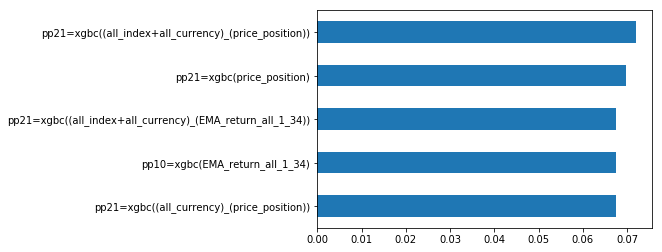

vote_lookbackM_rollM_top10


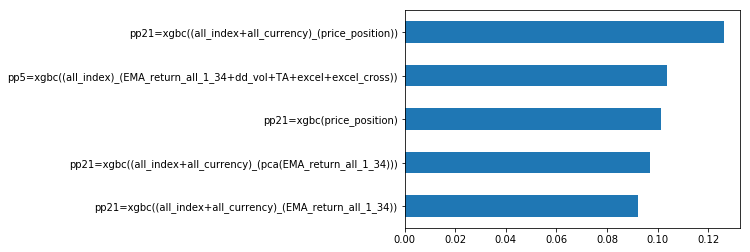

vote_lookbackM_rollM_top20


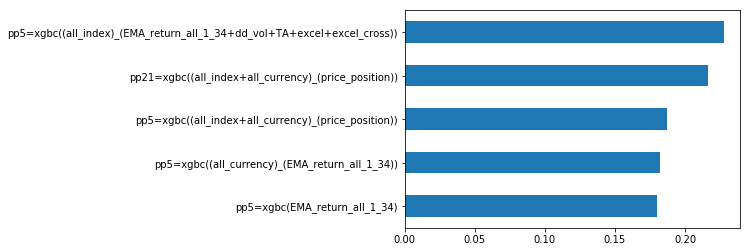

vote_lookbackM_rollM_top30


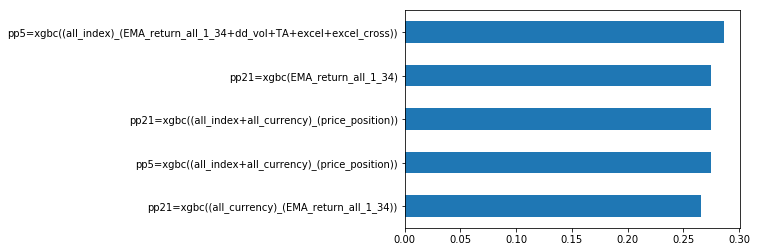

vote_lookbackM_rollM_top60


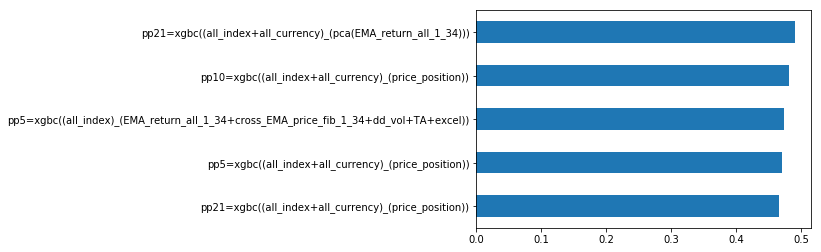

vote_lookbackM_rollM_top90


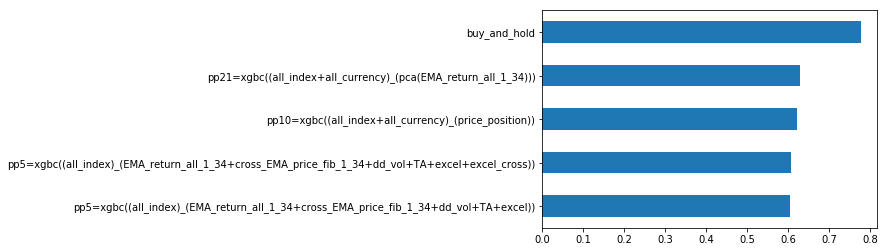

In [32]:
for n, top_l in chosen_df.items():
    print(n)
    fig, ax = plt.subplots()
    top_l.mean().sort_values().iloc[-5:].plot.barh()
    plt.show()

In [33]:
chosen_df_fn = os.path.join('output_others/vote_lookback_without_c3ema_chosen_cases.xlsx')
with pd.ExcelWriter(chosen_df_fn) as writer:
    for k, df in chosen_df.items():
        df.to_excel(writer, sheet_name=k[:30])

In [31]:
pred_sub.to_csv('output_others/vote_lookback_without_c3ema.csv')

In [34]:
proba_sub.to_csv('output_others/vote_lookback_without_c3ema_proba.csv')

In [45]:
#pred_sub.plot()

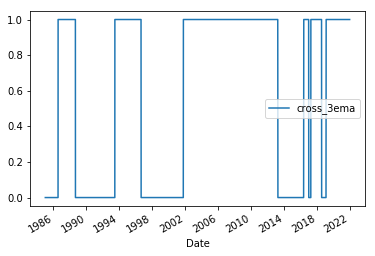

In [37]:
pred_3ema.plot()

In [33]:
#(pred_sub.vote_c3ema_roll_top4 - pred_sub.vote_c3ema_roll_top6).plot()

In [38]:
#pred_all = pd.DataFrame(pred_all).reindex(ret_all.index).ffill()
pred_all.shape

(9681, 168)

In [39]:
ret_all.shape

(9612, 168)

In [40]:
other_metric_all.shape

(168, 5)

In [41]:
empy_metric_all.shape

(168, 8)

In [42]:
pred_sub.shape

(9612, 35)

In [43]:
ret_sub = pred_sub.multiply(true_ret, 0)
ret_sub.shape

(9612, 35)

In [44]:
other_metric_sub = other_metric(ret_sub)
other_metric_sub

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback10A_rollA_top4,0.669996,0.089585,0.500936,0.513354,1.239258
vote_lookback10A_rollA_top6,0.664898,0.104360,0.498960,0.511970,1.238039
vote_lookback10A_rollA_top10,0.635976,0.099782,0.498752,0.512351,1.244177
vote_lookback10A_rollA_top20,0.604453,0.102279,0.498856,0.513081,1.242598
vote_lookback10A_rollA_top30,0.602996,0.101862,0.499480,0.513630,1.246830
vote_lookback10A_rollA_top60,0.592489,0.088752,0.498752,0.513257,1.243881
vote_lookback10A_rollA_top90,0.587599,0.082718,0.497607,0.512394,1.247138
vote_lookback5A_rollA_top4,0.594569,0.124129,0.496671,0.511461,1.236340
vote_lookback5A_rollA_top6,0.563983,0.124753,0.499584,0.514665,1.238872
vote_lookback5A_rollA_top10,0.520599,0.120591,0.500728,0.516986,1.237295


In [45]:
empy_metric_sub = empy_metric(ret_sub)
empy_metric_sub

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
vote_lookback10A_rollA_top4,2.825844,0.035804,0.341285,0.126561,-0.442183,-0.170373,0.080971,0.210149
vote_lookback10A_rollA_top6,3.098365,0.037674,0.359929,0.124183,-0.442167,-0.170012,0.085203,0.221596
vote_lookback10A_rollA_top10,2.102190,0.030126,0.304347,0.121990,-0.385787,-0.177336,0.078089,0.169879
vote_lookback10A_rollA_top20,2.396157,0.032574,0.329914,0.118439,-0.344907,-0.154128,0.094442,0.211341
vote_lookback10A_rollA_top30,1.792862,0.027293,0.287756,0.117651,-0.380272,-0.176717,0.071771,0.154443
vote_lookback10A_rollA_top60,2.219204,0.031126,0.320682,0.116911,-0.379844,-0.160066,0.081944,0.194458
vote_lookback10A_rollA_top90,1.782905,0.027196,0.290706,0.115149,-0.439564,-0.183787,0.061871,0.147978
vote_lookback5A_rollA_top4,3.518800,0.040334,0.388355,0.120487,-0.469941,-0.186783,0.085828,0.215942
vote_lookback5A_rollA_top6,3.029072,0.037210,0.365491,0.119483,-0.413832,-0.184777,0.089916,0.201379
vote_lookback5A_rollA_top10,3.429928,0.039793,0.397117,0.114864,-0.330530,-0.152871,0.120390,0.260301


In [46]:
empy_metric_sub.sort_values('sharpe_ratio')#.loc['buy_and_hold':]

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
vote_lookbackM_rollM_top20,0.657062,0.013329,0.182040,0.100596,-0.469789,-0.205429,0.028372,0.064883
vote_lookbackM_rollM_top10,0.720429,0.014326,0.189317,0.103469,-0.490613,-0.195347,0.029201,0.073338
vote_lookbackM_rollM_top60,1.061007,0.019141,0.230077,0.107628,-0.541282,-0.237754,0.035362,0.080508
vote_lookbackM_rollM_top6,1.101107,0.019656,0.236082,0.106526,-0.399879,-0.134625,0.049155,0.146006
vote_lookback5A_rollA_top30,1.336274,0.022496,0.257008,0.110230,-0.384514,-0.177418,0.058505,0.126797
vote_lookbackM_rollM_top4,1.341469,0.022556,0.258764,0.109348,-0.379600,-0.136689,0.059420,0.165014
vote_lookback3A_rollA_top30,1.413976,0.023374,0.266713,0.108879,-0.440872,-0.196969,0.053017,0.118666
vote_lookbackM_rollM_top30,1.344718,0.022593,0.269184,0.102584,-0.395912,-0.173904,0.057065,0.129916
vote_lookbackM_rollM_top90,1.497909,0.024291,0.271251,0.111413,-0.527818,-0.217938,0.046021,0.111458
vote_lookbackA_rollA_top6,1.676389,0.026146,0.285439,0.112658,-0.325453,-0.132691,0.080337,0.197044


In [79]:
pred_all_sub = pd.concat([pred_all, pred_sub], 1)
pred_all_sub.shape

(9681, 203)

In [80]:
ret_all_sub = pd.concat([ret_all, ret_sub], 1)
ret_all_sub.shape

(9612, 203)

In [81]:
other_metric_all_sub = pd.concat([other_metric_all, other_metric_sub])
other_metric_all_sub.shape

(203, 5)

In [82]:
empy_metric_all_sub = pd.concat([empy_metric_all, empy_metric_sub])
empy_metric_all_sub.shape

(203, 8)

In [60]:
"""name_list = []
se_list = []
name_list.append('buy_and_hold')
se_list.append(empy_metric(true_ret))

for name, r in result_all.items():
    #print(name)
    #print(r['empy_metric'])
    #empy_metric_all[name] = r['empy_metric'].iloc[0]
    name_list.append(name)
    se_list.append(r['empy_metric'].iloc[0])

    
empy_metric_all = pd.concat(se_list, 1, keys=name_list).T
"""

"name_list = []\nse_list = []\nname_list.append('buy_and_hold')\nse_list.append(empy_metric(true_ret))\n\nfor name, r in result_all.items():\n    #print(name)\n    #print(r['empy_metric'])\n    #empy_metric_all[name] = r['empy_metric'].iloc[0]\n    name_list.append(name)\n    se_list.append(r['empy_metric'].iloc[0])\n\n    \nempy_metric_all = pd.concat(se_list, 1, keys=name_list).T\n"

In [83]:
empy_metric_all_good_return = empy_metric_all_sub.sort_values('annual_return').loc['buy_and_hold':]
display(empy_metric_all_good_return)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),5.111786,0.048603,0.470855,0.114721,-0.482419,-0.193165,0.100749,0.251614
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),5.356772,0.049684,0.522568,0.102915,-0.328295,-0.105363,0.151340,0.471551


In [84]:
empy_metric_all_good_sharpe = empy_metric_all_sub.sort_values('sharpe_ratio').loc['buy_and_hold':]
display(empy_metric_all_good_sharpe)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
pp21=xgbc((all_index+all_currency)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position)),2.760795,0.035338,0.378096,0.107013,-0.476673,-0.175186,0.074135,0.201718
pp5=xgbc((all_index+all_currency)_(price_position)),2.524859,0.033581,0.384856,0.098428,-0.321522,-0.086956,0.104444,0.386185
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA))),3.242497,0.038615,0.387134,0.114887,-0.406742,-0.126521,0.094937,0.305205
vote_lookback5A_rollA_top4,3.518800,0.040334,0.388355,0.120487,-0.469941,-0.186783,0.085828,0.215942
pp21=xgbc(EMA_return_all_1_34),2.749644,0.035258,0.388480,0.102811,-0.321897,-0.113746,0.109531,0.309969
pp21=xgbc((all_currency)_(EMA_return_all_1_34)),2.909480,0.036391,0.393282,0.104893,-0.323988,-0.115241,0.112323,0.315783
vote_lookback5A_rollA_top10,3.429928,0.039793,0.397117,0.114864,-0.330530,-0.152871,0.120390,0.260301
vote_lookback5A_rollA_top20,3.314355,0.039072,0.399306,0.111597,-0.326279,-0.141733,0.119751,0.275674
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA))),2.958765,0.036732,0.403364,0.102415,-0.294900,-0.112953,0.124556,0.325195


In [85]:
empy_metric_all_good_sharpe.index[-7:]

Index(['pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34)))',
       'pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))',
       'pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))',
       'pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
       'pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
       'pp5=xgbc((all_currency)_(EMA_return_all_1_34))',
       'pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))'],
      dtype='object')

In [86]:
empy_metric_tmp = empy_metric_all_sub.sort_values('max_drawdown').loc['buy_and_hold':]
display(empy_metric_tmp)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
vote_lookbackM_rollM_top10,0.720429,0.014326,0.189317,0.103469,-0.490613,-0.195347,0.029201,0.073338
pp5=xgbc(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel+price_position),1.888251,0.028198,0.326199,0.100826,-0.489635,-0.170603,0.057589,0.165281
pp10=xgbc(pca(EMA_return_all_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+price_position)),0.394824,0.008762,0.135795,0.104486,-0.486626,-0.236664,0.018007,0.037025
pp10=xgbc(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel+excel_cross+price_position),0.177809,0.004300,0.093156,0.101026,-0.486527,-0.269655,0.008838,0.015946
...,...,...,...,...,...,...,...,...
pp21=xgbc((all_index+all_currency)_(dd_vol_ExpandingWindowMA_pct)),2.445982,0.032968,0.356257,0.107179,-0.271550,-0.113002,0.121406,0.291746
pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA))),2.412074,0.032700,0.355690,0.106320,-0.257139,-0.071316,0.127170,0.458527
pp10=xgbc(EMA_return_all_1_34+dd_vol_ExpandingWindowMA_pct),0.703012,0.014056,0.184781,0.105816,-0.253124,-0.090111,0.055530,0.155983
pp5=xgbc(price_position),1.440244,0.023664,0.312984,0.086744,-0.225168,-0.071864,0.105095,0.329290


In [87]:
empy_metric_tmp = empy_metric_all_sub.sort_values('avg_drawdown').loc['buy_and_hold':]
display(empy_metric_tmp)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
pp5=xgbc((all_index+all_currency)_(TA)),0.353075,0.007959,0.128113,0.104288,-0.470426,-0.224221,0.016919,0.035497
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel))),1.194975,0.020825,0.246750,0.106526,-0.455978,-0.222366,0.045671,0.093652
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA)),0.501240,0.010709,0.155290,0.102383,-0.408655,-0.219471,0.026205,0.048794
pp10=xgbc(EMA_return_all_1_34+dd_vol+TA+excel+price_position),0.202607,0.004849,0.098453,0.099762,-0.411866,-0.217961,0.011772,0.022245
...,...,...,...,...,...,...,...,...
pp10=xgbc(EMA_return_all_1_34+dd_vol_ExpandingWindowMA_pct),0.703012,0.014056,0.184781,0.105816,-0.253124,-0.090111,0.055530,0.155983
pp5=xgbc((all_index+all_currency)_(price_position)),2.524859,0.033581,0.384856,0.098428,-0.321522,-0.086956,0.104444,0.386185
pp5=xgbc(price_position),1.440244,0.023664,0.312984,0.086744,-0.225168,-0.071864,0.105095,0.329290
pp10=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA))),2.412074,0.032700,0.355690,0.106320,-0.257139,-0.071316,0.127170,0.458527


In [88]:
empy_metric_tmp = empy_metric_all_sub.sort_values('return/maxdd').loc['buy_and_hold':]
display(empy_metric_tmp)

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
buy_and_hold,4.930555,0.047776,0.378081,0.155384,-0.493126,-0.224901,0.096884,0.212431
pp21=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel+excel_cross)),2.416658,0.032737,0.348443,0.109719,-0.325104,-0.131002,0.100696,0.249893
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),5.111786,0.048603,0.470855,0.114721,-0.482419,-0.193165,0.100749,0.251614
pp21=xgbc((all_index+all_currency)_(EMA_return_all_1_34)),2.808893,0.035683,0.370421,0.111421,-0.345862,-0.148302,0.103172,0.240611
pp5=xgbc((all_index+all_currency)_(price_position)),2.524859,0.033581,0.384856,0.098428,-0.321522,-0.086956,0.104444,0.386185
pp5=xgbc(price_position),1.440244,0.023664,0.312984,0.086744,-0.225168,-0.071864,0.105095,0.329290
pp5=xgbc((all_currency)_(price_position)),1.474639,0.024040,0.313906,0.088019,-0.225168,-0.070055,0.106763,0.343155
pp21=xgbc(EMA_return_all_1_34),2.749644,0.035258,0.388480,0.102811,-0.321897,-0.113746,0.109531,0.309969
pp21=xgbc((all_currency)_(EMA_return_all_1_34)),2.909480,0.036391,0.393282,0.104893,-0.323988,-0.115241,0.112323,0.315783
pp10=xgbc((all_index)_(EMA_return_all_1_34+dd_vol)),3.110509,0.037755,0.410978,0.103123,-0.334998,-0.095359,0.112701,0.395921


In [71]:
"""
list_tmp = [
    'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))',
    'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))',
    'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
    'pp21=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
    'pp5=xgbc((XAU_USD+XAU_AUD+XAU_CNY+XAU_EUR+XAU_JPY)_(EMA_return_all_1_34))',
    'pp5=xgbc((XAU_USD+^GVZ+SI=F+EURUSD=X+JPYUSD=X+^GSPC+^VIX)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))'
]
pred_top_tmp = pd.concat([pred_all[n] for n in list_tmp], 1, keys=list_tmp).ffill()[start:].fillna(1)
pred_top_tmp.to_csv('pred_top_tmp3.csv')
"""

In [209]:
"""
pred_sub_future = pd.DataFrame(index=ret_all.index)

crossema_4xgb = pd.read_csv('output_others/20220428/pred_vote_crossema_4xgb.csv', index_col=0)
crossema_4xgb.index = pd.to_datetime(crossema_4xgb.index)
crossema_4xgb = crossema_4xgb[start:end]
pred_sub_future["pred_vote_crossema_4xgb"] = crossema_4xgb['y_pred']

crossema_6xgb = pd.read_csv('output_others/20220428/pred_vote_crossema_6xgb.csv', index_col=0)
crossema_6xgb.index = pd.to_datetime(crossema_6xgb.index)
crossema_6xgb = crossema_6xgb[start:end]
pred_sub_future["pred_vote_crossema_6xgb"] = crossema_6xgb['y_pred']
"""

In [ ]:
"""
ret_sub_future = pred_sub_future.multiply(true_ret, 0)
ret_sub_future.shape
"""

In [ ]:
"""
other_metric_sub_future = other_metric(ret_sub_future)
other_metric_sub_future
"""

In [ ]:
"""
empy_metric_sub_future = empy_metric(ret_sub_future)
empy_metric_sub_future
"""

In [ ]:
"""
pred_all_sub = pd.concat([pred_all_sub, pred_sub_future], 1)
pred_all_sub.shape
"""

In [ ]:
"""
ret_all_sub = pd.concat([ret_all_sub, ret_sub_future], 1)
ret_all_sub.shape
"""

In [ ]:
"""
other_metric_all_sub = pd.concat([other_metric_all_sub, other_metric_sub_future])
other_metric_all_sub.shape
"""

In [ ]:
"""
empy_metric_all_sub = pd.concat([empy_metric_all_sub, empy_metric_sub_future])
empy_metric_all_sub.shape
"""

In [ ]:
"""
empy_metric_tmp = empy_metric_all_sub.sort_values('return/maxdd').loc['buy_and_hold':]
display(empy_metric_tmp)
"""

In [ ]:
"""
empy_metric_tmp = empy_metric_all_sub.sort_values('sharpe_ratio').loc['buy_and_hold':]
display(empy_metric_tmp)
"""

In [89]:
cross3ema_nofuture = pd.read_csv('output_others/pred_c3ema_roll_no_future.csv', index_col=0)
cross3ema_nofuture.index = pd.to_datetime(cross3ema_nofuture.index)
cross3ema_nofuture = cross3ema_nofuture[start:end]
# cross3ema_nofuture.columns = ["{} (no future)".format(col) for col in cross3ema_nofuture.columns]

In [90]:
ret_sub_cross3ema_nofuture = cross3ema_nofuture.multiply(true_ret, 0)
ret_sub_cross3ema_nofuture.shape

(9612, 32)

In [91]:
other_metric_sub_cross3ema_nofuture = other_metric(ret_sub_cross3ema_nofuture)
other_metric_sub_cross3ema_nofuture

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback10_top1,0.584270,0.029966,0.512588,0.525285,1.233953
vote_c3ema_rollA_lookback10_top3,0.596650,0.032879,0.513317,0.525371,1.235286
vote_c3ema_rollA_lookback10_top5,0.602268,0.033711,0.512484,0.524443,1.237825
vote_c3ema_rollA_lookback10_top7,0.569288,0.044948,0.508843,0.522661,1.246053
vote_c3ema_rollA_lookback5_top1,0.598107,0.019977,0.517270,0.528614,1.229832
vote_c3ema_rollA_lookback5_top3,0.593113,0.022058,0.517270,0.528855,1.231711
vote_c3ema_rollA_lookback5_top5,0.597378,0.022890,0.515501,0.527168,1.231702
vote_c3ema_rollA_lookback5_top7,0.600707,0.026428,0.513213,0.525113,1.236405
vote_c3ema_rollA_lookback3_top1,0.603204,0.016023,0.516334,0.527596,1.232486
vote_c3ema_rollA_lookback3_top3,0.580108,0.021642,0.515501,0.527977,1.232692


In [92]:
empy_metric_sub_cross3ema_nofuture = empy_metric(ret_sub_cross3ema_nofuture)
empy_metric_sub_cross3ema_nofuture

,total_return,annual_return,sharpe_ratio,annual_volatility,max_drawdown,avg_drawdown,return/maxdd,return/avgdd
vote_c3ema_rollA_lookback10_top1,3.878887,0.042428,0.389096,0.127825,-0.422441,-0.219730,0.100434,0.193089
vote_c3ema_rollA_lookback10_top3,3.517621,0.040327,0.368079,0.130656,-0.497486,-0.178133,0.081062,0.226388
vote_c3ema_rollA_lookback10_top5,3.010574,0.037085,0.344322,0.130579,-0.493742,-0.214944,0.075110,0.172534
vote_c3ema_rollA_lookback10_top7,1.790977,0.027274,0.277280,0.125554,-0.499114,-0.227200,0.054646,0.120046
vote_c3ema_rollA_lookback5_top1,4.880665,0.047544,0.424073,0.129267,-0.397101,-0.210319,0.119727,0.226056
vote_c3ema_rollA_lookback5_top3,4.349025,0.044945,0.402301,0.130503,-0.436270,-0.186626,0.103021,0.240828
vote_c3ema_rollA_lookback5_top5,4.350047,0.044950,0.402231,0.130554,-0.401333,-0.200060,0.112002,0.224682
vote_c3ema_rollA_lookback5_top7,3.276340,0.038831,0.356276,0.131111,-0.488651,-0.222833,0.079466,0.174261
vote_c3ema_rollA_lookback3_top1,4.171070,0.044018,0.396438,0.130021,-0.422249,-0.224568,0.104247,0.196013
vote_c3ema_rollA_lookback3_top3,4.118091,0.043736,0.394253,0.130098,-0.455900,-0.191403,0.095934,0.228504


In [93]:
pred_all_sub = pd.concat([pred_all_sub, cross3ema_nofuture], 1)
pred_all_sub.shape

(9681, 235)

In [94]:
ret_all_sub = pd.concat([ret_all_sub, ret_sub_cross3ema_nofuture], 1)
ret_all_sub.shape

(9612, 235)

In [95]:
other_metric_all_sub = pd.concat([other_metric_all_sub, other_metric_sub_cross3ema_nofuture])
other_metric_all_sub.shape

(235, 5)

In [96]:
empy_metric_all_sub = pd.concat([empy_metric_all_sub, empy_metric_sub_cross3ema_nofuture])
empy_metric_all_sub.shape

(235, 8)

In [97]:
def print_all_result(ret_df, topn=10, strategy_list_sel=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

        if 'buy_and_hold' in strategy_list_sel:
            strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
        strategy_list_sel = ['buy_and_hold']+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
    return strategy_list_sel
    

the by period study included these

- 3ema cross (144,288,441) (with future) – c3ema

- 3ema cross found using 2 – showing the top 10 cases

- vote4 + 3ema (with future) – pred_vote_crossema_4xgb (with future)

- vote6 + 3ema (with future) – pred_vote_crossema_6xgb (with future)

- vote x – showing the top 10 cases

['vote_lookback3A_rollA_top4',
 'vote_lookback5A_rollA_top10',
 'vote_c3ema_rollA_lookback5_top3',
 'vote_lookback3A_rollA_top10',
 'vote_c3ema_rollA_lookback3_top5',
 'vote_c3ema_rollA_lookback5_top5',
 'vote_lookback3A_rollA_top90',
 'buy_and_hold',
 'vote_lookback5A_rollA_top6',
 'vote_c3ema_rollA_lookback1_top5',
 'vote_lookbackA_rollA_top20',
 'vote_lookback10A_rollA_top6',
 'vote_lookback5A_rollA_top4',
 'vote_lookback5A_rollA_top20',
 'vote_c3ema_rollA_lookback5_top1',
 'vote_lookbackA_rollA_top30',
 'vote_c3ema_rollA_lookback1_top3',
 'vote_c3ema_rollA_lookback3_top3',
 'vote_c3ema_rollA_lookback1_top1',
 'vote_c3ema_rollM_lookback5_top1',
 'vote_c3ema_rollA_lookback3_top1']

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback3A_rollA_top90,0.502601,0.093955,0.506034,0.522873,1.243951
vote_lookback3A_rollA_top4,0.587911,0.135158,0.494798,0.509998,1.241152
vote_lookbackA_rollA_top30,0.478672,0.118510,0.501665,0.519452,1.244796
vote_lookback3A_rollA_top10,0.526009,0.129747,0.501561,0.517603,1.241765
vote_lookback10A_rollA_top6,0.664898,0.104360,0.498960,0.511970,1.238039
vote_lookback5A_rollA_top6,0.563983,0.124753,0.499584,0.514665,1.238872
vote_lookback5A_rollA_top4,0.594569,0.124129,0.496671,0.511461,1.236340
vote_c3ema_rollA_lookback3_top3,0.580108,0.021642,0.515501,0.527977,1.232692
vote_c3ema_rollA_lookback1_top3,0.580108,0.021642,0.515501,0.527977,1.232692
vote_c3ema_rollA_lookback1_top1,0.603204,0.016023,0.516334,0.527596,1.232486


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.493126,-0.224901,0.212431
vote_lookback3A_rollA_top90,0.032089,0.346886,-0.401389,-0.154619,0.207534
vote_lookback3A_rollA_top4,0.034513,0.347162,-0.366281,-0.149744,0.230480
vote_lookbackA_rollA_top30,0.031386,0.348181,-0.333573,-0.137947,0.227524
vote_lookback3A_rollA_top10,0.034212,0.352599,-0.427878,-0.202196,0.169203
vote_lookback10A_rollA_top6,0.037674,0.359929,-0.442167,-0.170012,0.221596
vote_lookback5A_rollA_top6,0.037210,0.365491,-0.413832,-0.184777,0.201379
vote_lookback5A_rollA_top4,0.040334,0.388355,-0.469941,-0.186783,0.215942
vote_c3ema_rollA_lookback3_top3,0.043736,0.394253,-0.455900,-0.191403,0.228504
vote_c3ema_rollA_lookback1_top3,0.043736,0.394253,-0.455900,-0.191403,0.228504


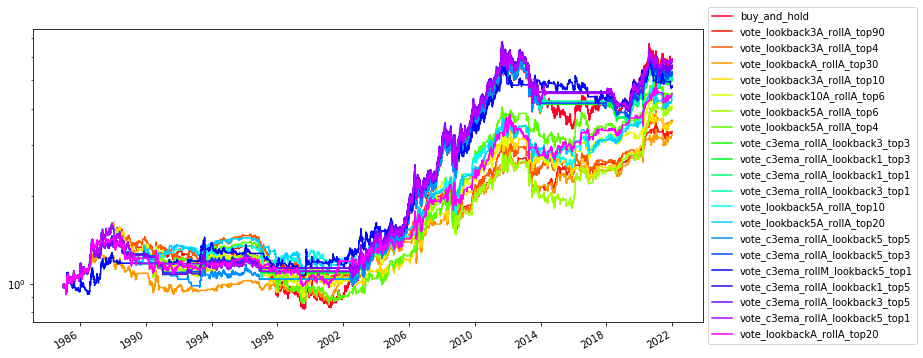

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback3A_rollA_top90,0.503699,0.091770,0.498076,0.485899,1.261866
vote_lookback3A_rollA_top4,0.597810,0.144760,0.483279,0.475743,1.255482
vote_lookbackA_rollA_top30,0.501628,0.114269,0.503107,0.490855,1.252323
vote_lookback3A_rollA_top10,0.556674,0.127590,0.491270,0.481127,1.260531
vote_lookback10A_rollA_top6,0.823616,0.076673,0.481207,0.481135,1.258596
vote_lookback5A_rollA_top6,0.586268,0.130551,0.486534,0.478041,1.257255
vote_lookback5A_rollA_top4,0.612311,0.127590,0.477656,0.471725,1.267598
vote_c3ema_rollA_lookback3_top3,0.303048,0.030491,0.506955,0.491211,1.248470
vote_c3ema_rollA_lookback1_top3,0.303048,0.030491,0.506955,0.491211,1.248470
vote_c3ema_rollA_lookback1_top1,0.329387,0.022202,0.500148,0.481581,1.262063


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.481481,-0.272448,-0.155021
vote_lookback3A_rollA_top90,-0.031710,-0.393117,-0.385541,-0.235158,-0.134844
vote_lookback3A_rollA_top4,-0.026079,-0.283521,-0.365009,-0.197823,-0.131828
vote_lookbackA_rollA_top30,-0.022562,-0.265163,-0.299567,-0.206057,-0.109494
vote_lookback3A_rollA_top10,-0.031226,-0.329316,-0.427878,-0.282368,-0.110586
vote_lookback10A_rollA_top6,-0.031793,-0.236584,-0.429351,-0.253570,-0.125381
vote_lookback5A_rollA_top6,-0.028687,-0.269172,-0.400366,-0.263165,-0.109009
vote_lookback5A_rollA_top4,-0.038529,-0.382319,-0.457764,-0.240101,-0.160470
vote_c3ema_rollA_lookback3_top3,-0.017829,-0.268637,-0.227117,-0.172761,-0.103203
vote_c3ema_rollA_lookback1_top3,-0.017829,-0.268637,-0.227117,-0.172761,-0.103203


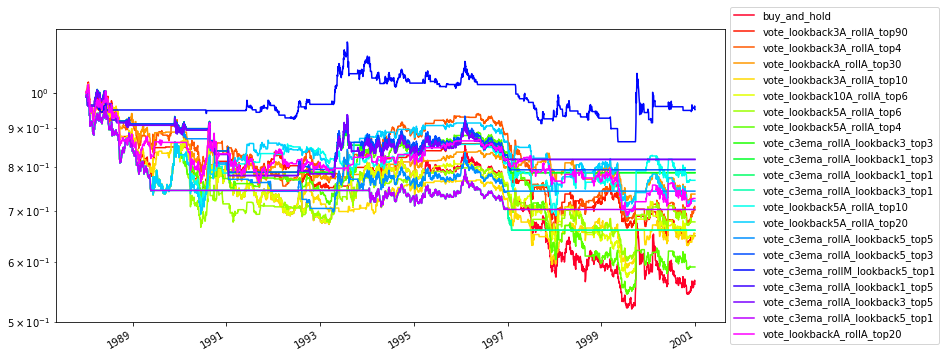

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback3A_rollA_top90,0.422137,0.099546,0.506983,0.559967,1.253203
vote_lookback3A_rollA_top4,0.514665,0.140412,0.496159,0.538670,1.253031
vote_lookbackA_rollA_top30,0.473813,0.127139,0.506285,0.552690,1.244533
vote_lookback3A_rollA_top10,0.435056,0.138316,0.501746,0.552167,1.243027
vote_lookback10A_rollA_top6,0.501397,0.146350,0.498953,0.542479,1.240902
vote_lookback5A_rollA_top6,0.457402,0.128886,0.494763,0.541985,1.255578
vote_lookback5A_rollA_top4,0.534567,0.146001,0.506285,0.546702,1.226578
vote_c3ema_rollA_lookback3_top3,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollA_lookback1_top3,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollA_lookback1_top1,0.869064,0.009431,0.532123,0.543592,1.205330


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.290117,-0.057719,2.880430
vote_lookback3A_rollA_top90,0.081111,0.702999,-0.228737,-0.033602,2.413873
vote_lookback3A_rollA_top4,0.079200,0.624272,-0.296812,-0.043499,1.820752
vote_lookbackA_rollA_top30,0.094195,0.765149,-0.211252,-0.032454,2.902400
vote_lookback3A_rollA_top10,0.096638,0.781093,-0.196691,-0.024443,3.953639
vote_lookback10A_rollA_top6,0.099478,0.779798,-0.223172,-0.026776,3.715175
vote_lookback5A_rollA_top6,0.075391,0.604752,-0.283253,-0.038013,1.983282
vote_lookback5A_rollA_top4,0.121683,0.876313,-0.223172,-0.029759,4.088969
vote_c3ema_rollA_lookback3_top3,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_c3ema_rollA_lookback1_top3,0.150511,0.865565,-0.290117,-0.053233,2.827429


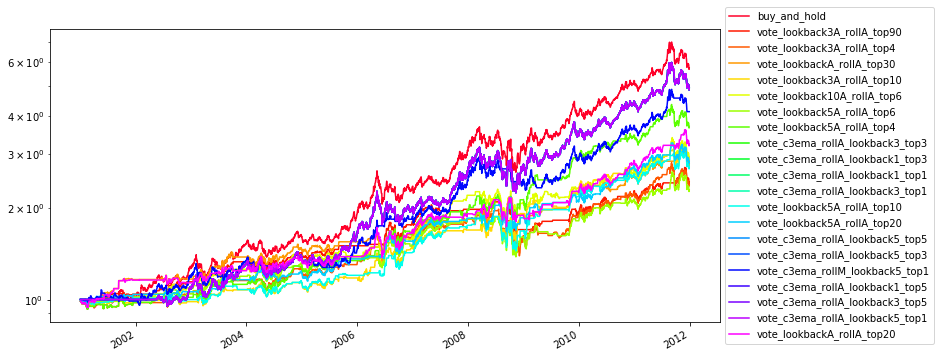

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback3A_rollA_top90,0.549904,0.095101,0.527831,0.511344,1.217337
vote_lookback3A_rollA_top4,0.608445,0.128722,0.505758,0.492114,1.228350
vote_lookbackA_rollA_top30,0.475048,0.103746,0.510557,0.494949,1.234705
vote_lookback3A_rollA_top10,0.528791,0.138329,0.510557,0.495463,1.245304
vote_lookback10A_rollA_top6,0.629559,0.103746,0.513436,0.498476,1.226770
vote_lookback5A_rollA_top6,0.562380,0.105668,0.503839,0.489761,1.256918
vote_lookback5A_rollA_top4,0.542226,0.088377,0.510557,0.495575,1.235324
vote_c3ema_rollA_lookback3_top3,0.495202,0.000961,0.521113,0.505814,1.261295
vote_c3ema_rollA_lookback1_top3,0.495202,0.000961,0.521113,0.505814,1.261295
vote_c3ema_rollA_lookback1_top1,0.590211,0.000961,0.533589,0.515447,1.246954


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.412616,-0.229167,-0.390783
vote_lookback3A_rollA_top90,-0.006626,0.014926,-0.270359,-0.150195,-0.044113
vote_lookback3A_rollA_top4,-0.021647,-0.088807,-0.241657,-0.119496,-0.181155
vote_lookbackA_rollA_top30,-0.027426,-0.169899,-0.284831,-0.176263,-0.155598
vote_lookback3A_rollA_top10,-0.041996,-0.259689,-0.299198,-0.168550,-0.249163
vote_lookback10A_rollA_top6,-0.019467,-0.074766,-0.289857,-0.140604,-0.138452
vote_lookback5A_rollA_top6,-0.056704,-0.363962,-0.354721,-0.220312,-0.257380
vote_lookback5A_rollA_top4,-0.028546,-0.172277,-0.269647,-0.140539,-0.203121
vote_c3ema_rollA_lookback3_top3,-0.061283,-0.424617,-0.335344,-0.231583,-0.264628
vote_c3ema_rollA_lookback1_top3,-0.061283,-0.424617,-0.335344,-0.231583,-0.264628


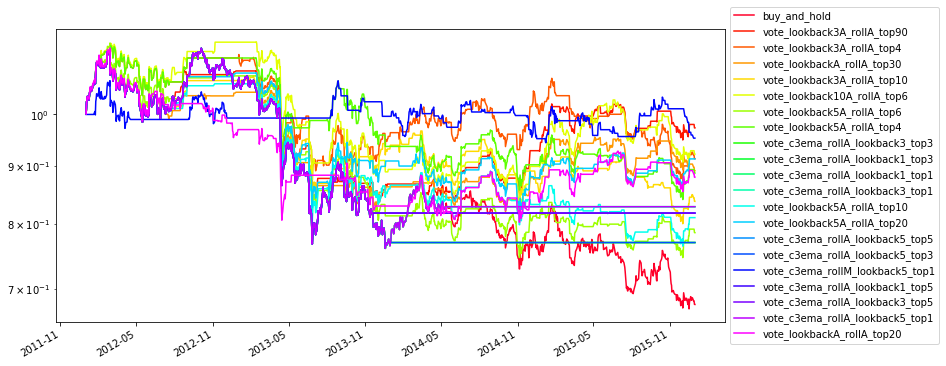

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_lookback3A_rollA_top90,0.389635,0.102433,0.501599,0.548440,1.244898
vote_lookback3A_rollA_top4,0.502239,0.144046,0.499040,0.535032,1.229397
vote_lookbackA_rollA_top30,0.379399,0.108835,0.500320,0.548061,1.236907
vote_lookback3A_rollA_top10,0.409469,0.145327,0.509917,0.556250,1.235509
vote_lookback10A_rollA_top6,0.497761,0.108195,0.518874,0.555270,1.233298
vote_lookback5A_rollA_top6,0.515675,0.147887,0.525272,0.559553,1.180221
vote_lookback5A_rollA_top4,0.519514,0.129962,0.500960,0.535714,1.232893
vote_c3ema_rollA_lookback3_top3,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback1_top3,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback1_top1,0.539347,0.001921,0.510557,0.543298,1.261437


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.185126,-0.066784,1.372467
vote_lookback3A_rollA_top90,0.053475,0.684633,-0.131736,-0.032279,1.656636
vote_lookback3A_rollA_top4,0.069708,0.751879,-0.134787,-0.048617,1.433819
vote_lookbackA_rollA_top30,0.062207,0.756285,-0.123624,-0.033103,1.879186
vote_lookback3A_rollA_top10,0.063638,0.758775,-0.140651,-0.043802,1.452863
vote_lookback10A_rollA_top6,0.065321,0.714409,-0.155646,-0.035400,1.845229
vote_lookback5A_rollA_top6,0.127501,1.303057,-0.129291,-0.033806,3.771517
vote_lookback5A_rollA_top4,0.065750,0.715488,-0.177131,-0.074214,0.885954
vote_c3ema_rollA_lookback3_top3,0.034728,0.369491,-0.185126,-0.052298,0.664044
vote_c3ema_rollA_lookback1_top3,0.034728,0.369491,-0.185126,-0.052298,0.664044


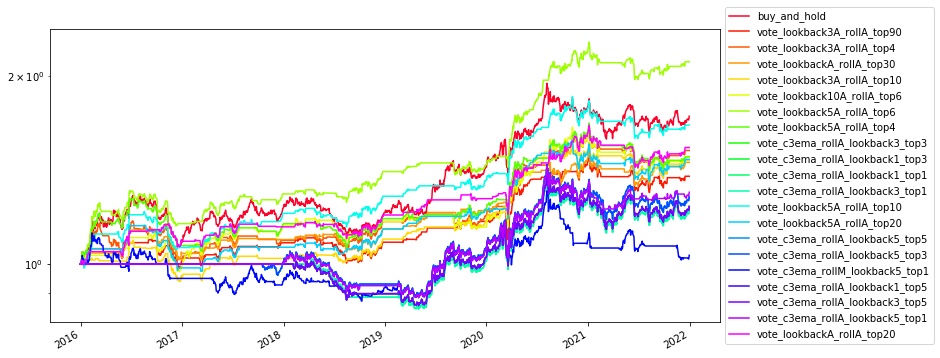

['buy_and_hold',
 'vote_lookback3A_rollA_top90',
 'vote_lookback3A_rollA_top4',
 'vote_lookbackA_rollA_top30',
 'vote_lookback3A_rollA_top10',
 'vote_lookback10A_rollA_top6',
 'vote_lookback5A_rollA_top6',
 'vote_lookback5A_rollA_top4',
 'vote_c3ema_rollA_lookback3_top3',
 'vote_c3ema_rollA_lookback1_top3',
 'vote_c3ema_rollA_lookback1_top1',
 'vote_c3ema_rollA_lookback3_top1',
 'vote_lookback5A_rollA_top10',
 'vote_lookback5A_rollA_top20',
 'vote_c3ema_rollA_lookback5_top5',
 'vote_c3ema_rollA_lookback5_top3',
 'vote_c3ema_rollM_lookback5_top1',
 'vote_c3ema_rollA_lookback1_top5',
 'vote_c3ema_rollA_lookback3_top5',
 'vote_c3ema_rollA_lookback5_top1',
 'vote_lookbackA_rollA_top20']

In [98]:
### sharpe_ratio selected cases
### 




list_tmp = [i for i in ret_all_sub.columns if (i == 'buy_and_hold')
#             or (i == 'c3ema')
#             or (i == 'vote_c3ema_lookback10A_rollA_top4')
            or ('pred_vote_crossema_' in i)
           ]
# print(list_tmp)
best = list(empy_metric_sub.sort_values('sharpe_ratio').index[-10:])
# print(best)
# if best not in list_tmp:
list_tmp += best
    
best = list(empy_metric_sub_cross3ema_nofuture.sort_values('sharpe_ratio').index[-10:])
list_tmp += best


list_tmp = list(set(list_tmp))
display(list_tmp)

ret_tmp = ret_all_sub[list_tmp]
strategy_list_sel = print_all_result(ret_tmp, topn=len(list_tmp))

print_all_result(ret_tmp['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2001':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2016':'2021'], strategy_list_sel=strategy_list_sel)


'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
pp5=xgbc(EMA_return_all_1_34),0.378589,0.180106,0.503121,0.526518,1.242406
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.514981,0.112267,0.498231,0.514747,1.234837
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.467020,0.169077,0.502289,0.520606,1.237299
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.487724,0.184788,0.503849,0.521331,1.234739
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.479921,0.153678,0.502289,0.520052,1.235304
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.472950,0.168037,0.502393,0.520458,1.236951
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.470454,0.110706,0.496359,0.514153,1.236813
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.510716,0.095099,0.493342,0.510084,1.230482
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.389409,0.185725,0.503745,0.526583,1.237568
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),0.451727,0.142857,0.504890,0.524182,1.230674


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.493126,-0.224901,0.212431
pp5=xgbc(EMA_return_all_1_34),0.035539,0.419825,-0.433445,-0.139117,0.255460
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.042831,0.420085,-0.505778,-0.176215,0.243059
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.040872,0.432227,-0.287102,-0.110484,0.369937
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.043399,0.435514,-0.342730,-0.126991,0.341750
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.042948,0.438149,-0.476521,-0.177294,0.242242
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.041381,0.439107,-0.350740,-0.130336,0.317494
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.041632,0.443063,-0.432837,-0.164634,0.252879
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.048603,0.470855,-0.482419,-0.193165,0.251614
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.041626,0.477889,-0.433445,-0.141143,0.294922


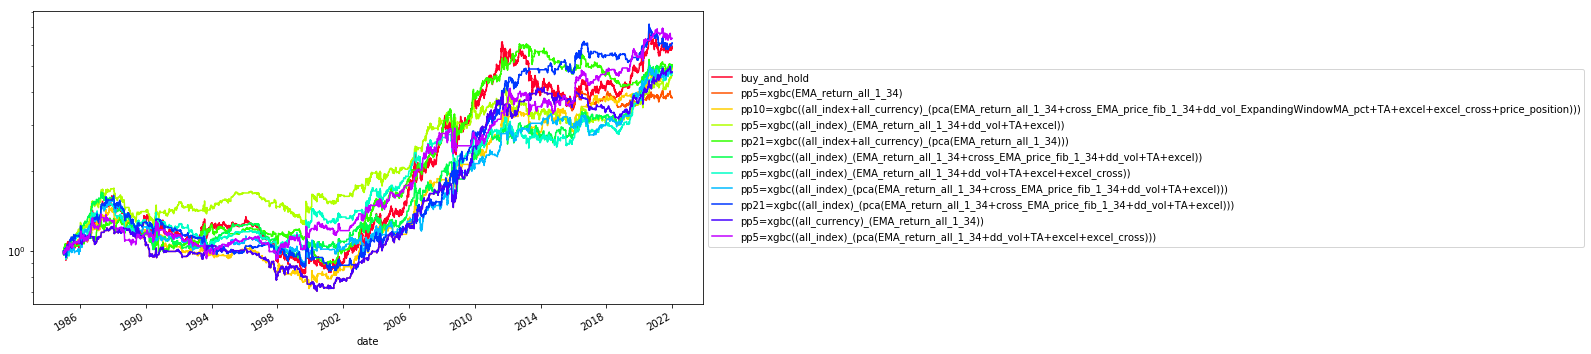

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
pp5=xgbc(EMA_return_all_1_34),0.369636,0.189757,0.494229,0.475580,1.268930
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.550755,0.140320,0.484759,0.475013,1.269678
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.486830,0.173475,0.507843,0.495441,1.235154
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.477360,0.202487,0.491270,0.477991,1.255656
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.497484,0.154529,0.492453,0.480071,1.260101
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.484463,0.165483,0.505475,0.492975,1.237266
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.505771,0.142096,0.485943,0.473961,1.259096
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.492749,0.118117,0.475880,0.463063,1.270130
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.369636,0.189757,0.494229,0.475580,1.268930
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),0.492453,0.158378,0.507547,0.495192,1.231281


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.481481,-0.272448,-0.155021
pp5=xgbc(EMA_return_all_1_34),-0.038393,-0.492678,-0.433445,-0.219624,-0.174812
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),-0.040835,-0.389895,-0.492696,-0.300822,-0.135745
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),-0.006992,-0.033130,-0.278419,-0.138191,-0.050594
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),-0.026798,-0.264549,-0.336210,-0.155713,-0.172097
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),-0.030989,-0.316398,-0.454336,-0.292339,-0.106003
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),-0.009147,-0.055729,-0.328467,-0.198050,-0.046183
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),-0.030559,-0.284728,-0.432837,-0.292951,-0.104314
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),-0.040998,-0.405340,-0.464747,-0.318486,-0.128728
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),-0.038393,-0.492678,-0.433445,-0.219624,-0.174812


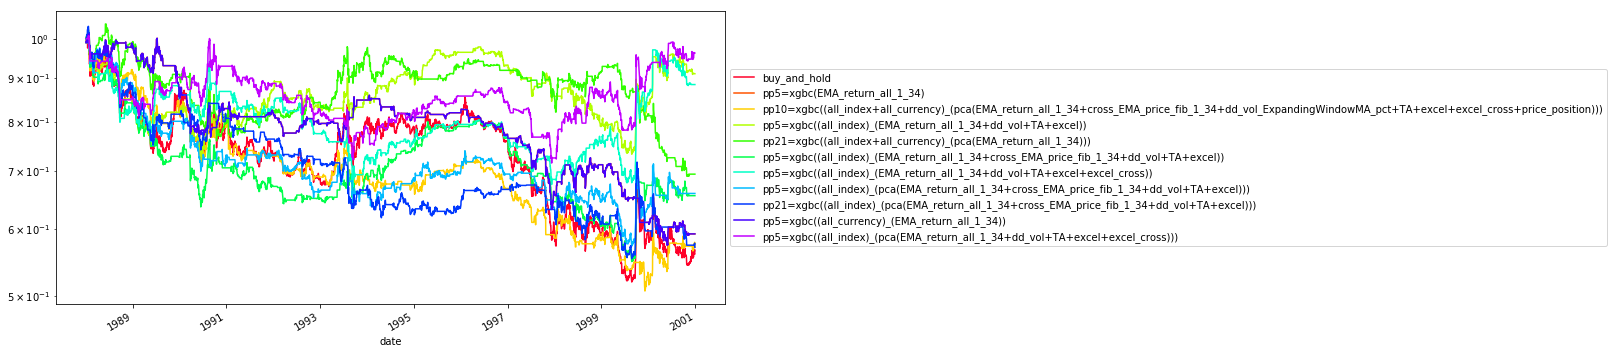

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
pp5=xgbc(EMA_return_all_1_34),0.439595,0.166608,0.517458,0.569500,1.216605
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.476257,0.091512,0.498953,0.544721,1.226738
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.423883,0.151589,0.491271,0.541186,1.257778
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.604749,0.170800,0.524791,0.556582,1.203294
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.463687,0.128187,0.498254,0.545181,1.251440
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.436103,0.150891,0.494413,0.543635,1.261842
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.412709,0.085575,0.497556,0.549915,1.249349
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.567039,0.082431,0.503841,0.541872,1.213967
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.439595,0.166608,0.517458,0.569500,1.216605
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),0.381634,0.132379,0.499302,0.556267,1.243238


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.290117,-0.057719,2.880430
pp5=xgbc(EMA_return_all_1_34),0.141840,1.167809,-0.196811,-0.023203,6.112937
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.122245,0.908894,-0.209633,-0.038586,3.168085
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.074289,0.668058,-0.206924,-0.037724,1.969251
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.160368,1.081674,-0.255295,-0.035089,4.570332
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.082402,0.663747,-0.251754,-0.050854,1.620380
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.067851,0.620062,-0.292717,-0.056302,1.205123
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.088064,0.785529,-0.155281,-0.029582,2.976949
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.142742,0.999856,-0.170527,-0.032599,4.378756
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.141840,1.167809,-0.196811,-0.023203,6.112937


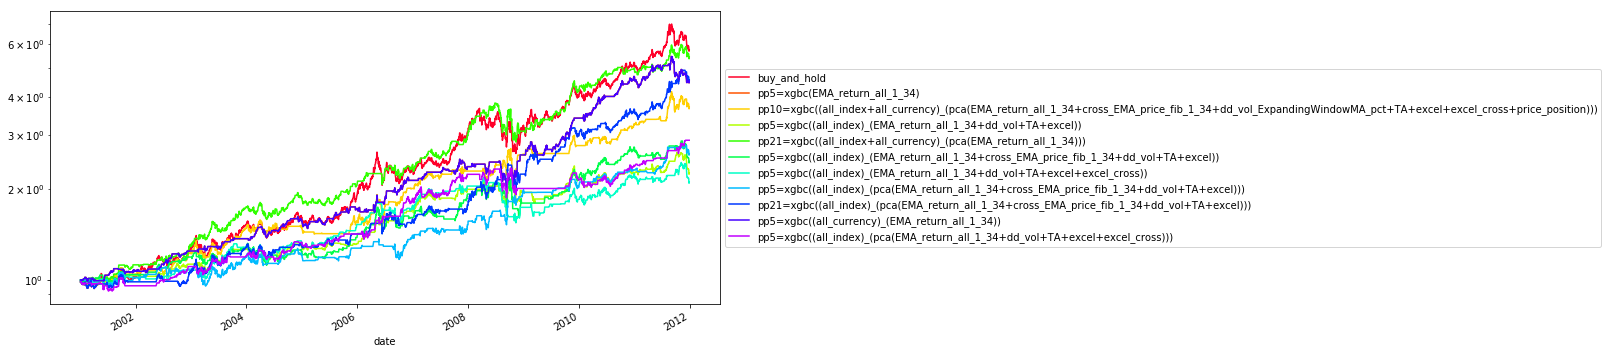

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
pp5=xgbc(EMA_return_all_1_34),0.358925,0.120077,0.532630,0.524064,1.198483
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.574856,0.091258,0.506718,0.492487,1.223714
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.506718,0.150817,0.494242,0.479167,1.244598
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.380998,0.161383,0.516315,0.501259,1.221060
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.523992,0.155620,0.515355,0.500000,1.200235
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.511516,0.164265,0.510557,0.495310,1.222302
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.341651,0.101825,0.492322,0.466292,1.198748
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.373321,0.077810,0.508637,0.491003,1.190661
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.363724,0.127762,0.533589,0.525066,1.192836
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),0.513436,0.118156,0.520154,0.504673,1.211441


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.412616,-0.229167,-0.390783
pp5=xgbc(EMA_return_all_1_34),0.021734,0.268250,-0.186102,-0.053797,0.403999
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),-0.013797,-0.051135,-0.225406,-0.097386,-0.141672
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),-0.039535,-0.279708,-0.254473,-0.146094,-0.270611
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),-0.008567,-0.026816,-0.231458,-0.089134,-0.096109
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.016937,0.199778,-0.160455,-0.073144,0.231561
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),-0.010734,-0.039694,-0.207945,-0.125725,-0.085376
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.022433,0.298695,-0.140264,-0.039897,0.562273
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.033130,0.416460,-0.116992,-0.028363,1.168074
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.029335,0.346901,-0.160771,-0.051840,0.565876


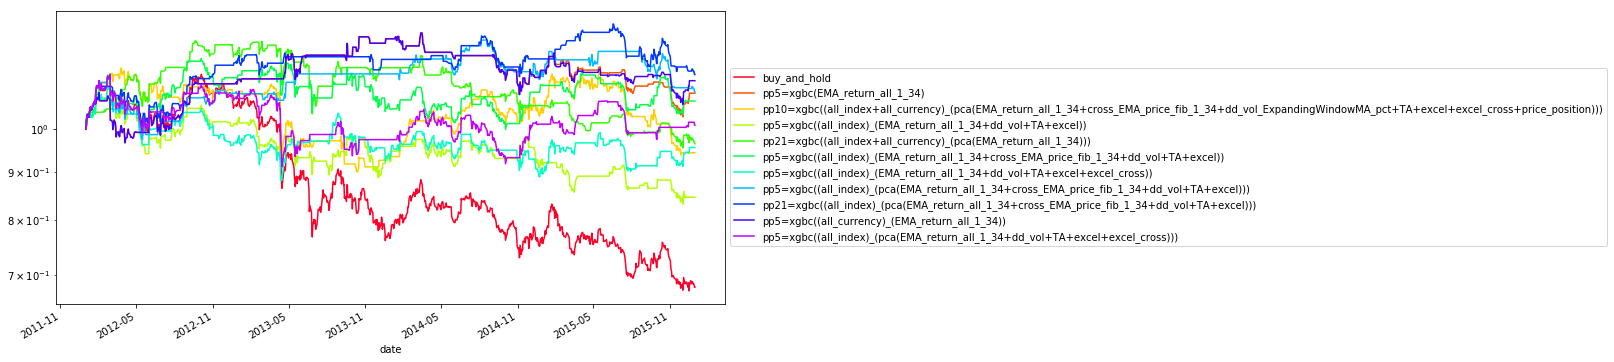

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
pp5=xgbc(EMA_return_all_1_34),0.357646,0.218950,0.482406,0.525939,1.285191
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.455534,0.080026,0.518874,0.560393,1.208650
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.443378,0.170294,0.506718,0.548341,1.227191
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.439539,0.191421,0.484965,0.524017,1.281636
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.487524,0.182458,0.526552,0.564304,1.202255
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.458733,0.181818,0.506718,0.546722,1.206362
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.590531,0.080026,0.515675,0.543879,1.217304
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.554702,0.071703,0.507997,0.539792,1.250288
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.420985,0.248399,0.485605,0.525836,1.255452
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))),0.454255,0.119718,0.512476,0.553521,1.208234


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.185126,-0.066784,1.372467
pp5=xgbc(EMA_return_all_1_34),0.009000,0.151098,-0.130456,-0.065086,0.138276
pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position))),0.093473,0.961870,-0.124911,-0.028840,3.241139
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel)),0.072554,0.803504,-0.149111,-0.058236,1.245850
pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34))),0.011691,0.170628,-0.266310,-0.139409,0.083865
pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)),0.100507,0.989184,-0.128296,-0.039346,2.554420
pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)),0.096567,1.027332,-0.135767,-0.046885,2.059684
pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.082156,0.779345,-0.161866,-0.051824,1.585282
pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))),0.044629,0.455268,-0.198443,-0.099427,0.448858
pp5=xgbc((all_currency)_(EMA_return_all_1_34)),0.040876,0.492300,-0.215589,-0.087933,0.464850


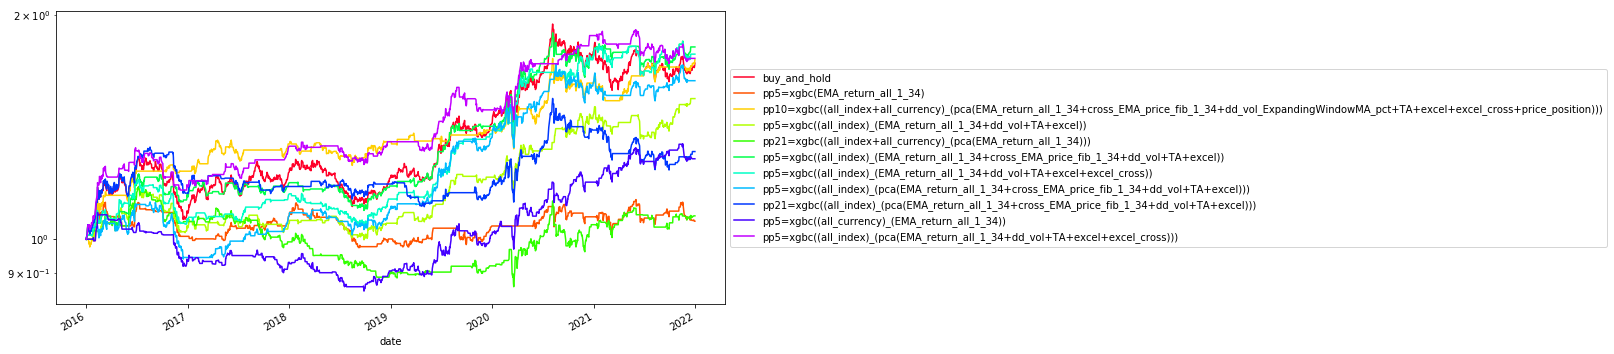

['buy_and_hold',
 'pp5=xgbc(EMA_return_all_1_34)',
 'pp10=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol_ExpandingWindowMA_pct+TA+excel+excel_cross+price_position)))',
 'pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel))',
 'pp21=xgbc((all_index+all_currency)_(pca(EMA_return_all_1_34)))',
 'pp5=xgbc((all_index)_(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel))',
 'pp5=xgbc((all_index)_(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross))',
 'pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
 'pp21=xgbc((all_index)_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol+TA+excel)))',
 'pp5=xgbc((all_currency)_(EMA_return_all_1_34))',
 'pp5=xgbc((all_index)_(pca(EMA_return_all_1_34+dd_vol+TA+excel+excel_cross)))']

In [99]:
### new feature only, sharpe_ratio top10
list_tmp = [i for i in ret_all.columns if ('buy_and_hold' in i) 
            or ('dd_vol' in i)
            or ('price_position' in i)
            or ('TA' in i)
            or ('EMA_' in i)
           ]
ret_tmp = ret_all[list_tmp]
strategy_list_sel = print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2001':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2016':'2021'], strategy_list_sel=strategy_list_sel)


'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top1,0.603204,0.016023,0.516334,0.527596,1.232486
vote_lookback5A_rollA_top10,0.520599,0.120591,0.500728,0.516986,1.237295
vote_lookback5A_rollA_top20,0.507179,0.115805,0.505410,0.522051,1.238149
vote_c3ema_rollA_lookback5_top5,0.597378,0.022890,0.515501,0.527168,1.231702
vote_c3ema_rollA_lookback5_top3,0.593113,0.022058,0.517270,0.528855,1.231711
vote_c3ema_rollM_lookback5_top1,0.528922,0.075330,0.499480,0.515539,1.235407
vote_c3ema_rollA_lookback1_top5,0.584478,0.021642,0.515710,0.527946,1.230647
vote_c3ema_rollA_lookback3_top5,0.584478,0.021642,0.515710,0.527946,1.230647
vote_c3ema_rollA_lookback5_top1,0.598107,0.019977,0.517270,0.528614,1.229832
vote_lookbackA_rollA_top20,0.490012,0.126834,0.504890,0.522293,1.237725


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.047776,0.378081,-0.493126,-0.224901,0.212431
vote_c3ema_rollA_lookback3_top1,0.044018,0.396438,-0.422249,-0.224568,0.196013
vote_lookback5A_rollA_top10,0.039793,0.397117,-0.330530,-0.152871,0.260301
vote_lookback5A_rollA_top20,0.039072,0.399306,-0.326279,-0.141733,0.275674
vote_c3ema_rollA_lookback5_top5,0.044950,0.402231,-0.401333,-0.200060,0.224682
vote_c3ema_rollA_lookback5_top3,0.044945,0.402301,-0.436270,-0.186626,0.240828
vote_c3ema_rollM_lookback5_top1,0.041920,0.408645,-0.297077,-0.121349,0.345451
vote_c3ema_rollA_lookback1_top5,0.046378,0.413775,-0.422179,-0.176478,0.262795
vote_c3ema_rollA_lookback3_top5,0.046378,0.413775,-0.422179,-0.176478,0.262795
vote_c3ema_rollA_lookback5_top1,0.047544,0.424073,-0.397101,-0.210319,0.226056


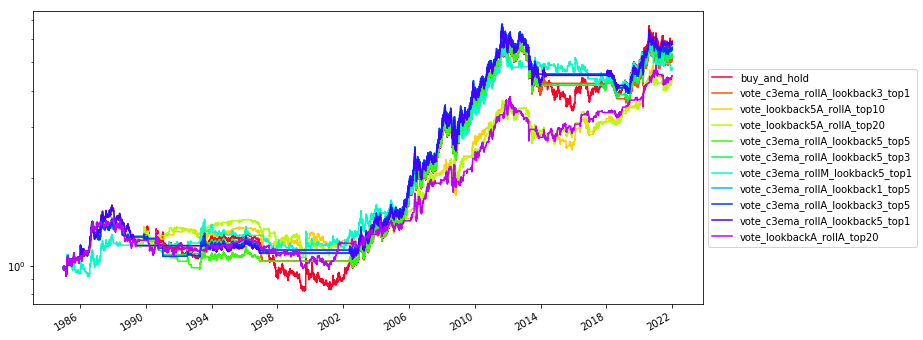

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top1,0.329387,0.022202,0.500148,0.481581,1.262063
vote_lookback5A_rollA_top10,0.521752,0.119301,0.492453,0.480998,1.248417
vote_lookback5A_rollA_top20,0.518793,0.102131,0.497189,0.485454,1.253396
vote_c3ema_rollA_lookback5_top5,0.333531,0.034044,0.503699,0.487134,1.252469
vote_c3ema_rollA_lookback5_top3,0.312518,0.031676,0.508139,0.493371,1.247781
vote_c3ema_rollM_lookback5_top1,0.290027,0.061279,0.487422,0.457143,1.233008
vote_c3ema_rollA_lookback1_top5,0.322877,0.029899,0.508434,0.494042,1.245302
vote_c3ema_rollA_lookback3_top5,0.322877,0.029899,0.508434,0.494042,1.245302
vote_c3ema_rollA_lookback5_top1,0.323173,0.022202,0.501628,0.483516,1.257374
vote_lookbackA_rollA_top20,0.517017,0.125518,0.500740,0.488838,1.253208


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.042235,-0.283945,-0.481481,-0.272448,-0.155021
vote_c3ema_rollA_lookback3_top1,-0.030509,-0.565819,-0.341600,-0.271744,-0.112271
vote_lookback5A_rollA_top10,-0.019519,-0.189432,-0.314569,-0.192665,-0.101310
vote_lookback5A_rollA_top20,-0.024087,-0.257429,-0.309140,-0.173569,-0.138776
vote_c3ema_rollA_lookback5_top5,-0.021912,-0.316720,-0.308356,-0.217644,-0.100680
vote_c3ema_rollA_lookback5_top3,-0.017193,-0.254980,-0.221465,-0.167931,-0.102379
vote_c3ema_rollM_lookback5_top1,-0.003735,-0.011272,-0.260833,-0.107084,-0.034877
vote_c3ema_rollA_lookback1_top5,-0.014881,-0.208766,-0.231660,-0.164219,-0.090619
vote_c3ema_rollA_lookback3_top5,-0.014881,-0.208766,-0.231660,-0.164219,-0.090619
vote_c3ema_rollA_lookback5_top1,-0.025958,-0.484895,-0.298932,-0.258724,-0.100331


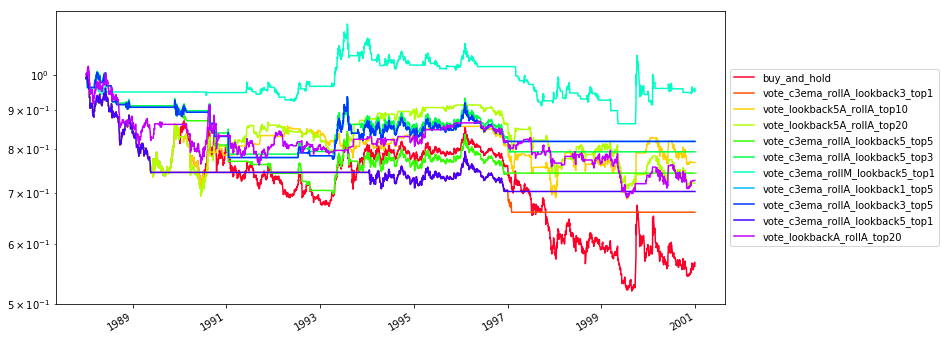

'2001-01-02 00:00:00 to 2011-12-30 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top1,0.869064,0.009431,0.532123,0.543592,1.205330
vote_lookback5A_rollA_top10,0.427025,0.129934,0.496508,0.547016,1.246001
vote_lookback5A_rollA_top20,0.420042,0.135871,0.503492,0.556110,1.243849
vote_c3ema_rollA_lookback5_top5,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollA_lookback5_top3,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollM_lookback5_top1,0.770950,0.053790,0.521997,0.542572,1.218839
vote_c3ema_rollA_lookback1_top5,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollA_lookback3_top5,0.869064,0.009431,0.532123,0.543592,1.205330
vote_c3ema_rollA_lookback5_top1,0.869064,0.009431,0.532123,0.543592,1.205330
vote_lookbackA_rollA_top20,0.481494,0.130632,0.514665,0.560551,1.235537


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.166255,0.914087,-0.290117,-0.057719,2.880430
vote_c3ema_rollA_lookback3_top1,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_lookback5A_rollA_top10,0.091694,0.742857,-0.247412,-0.024164,3.794586
vote_lookback5A_rollA_top20,0.095823,0.795792,-0.220799,-0.026989,3.550447
vote_c3ema_rollA_lookback5_top5,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_c3ema_rollA_lookback5_top3,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_c3ema_rollM_lookback5_top1,0.132836,0.890977,-0.224614,-0.059094,2.247865
vote_c3ema_rollA_lookback1_top5,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_c3ema_rollA_lookback3_top5,0.150511,0.865565,-0.290117,-0.053233,2.827429
vote_c3ema_rollA_lookback5_top1,0.150511,0.865565,-0.290117,-0.053233,2.827429


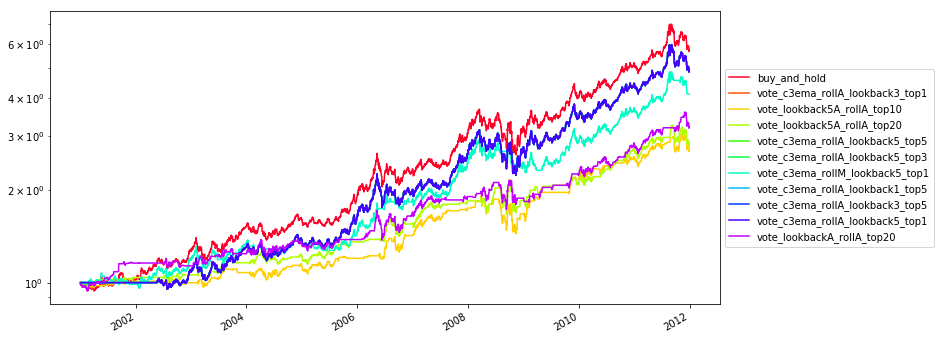

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top1,0.590211,0.000961,0.533589,0.515447,1.246954
vote_lookback5A_rollA_top10,0.562380,0.097022,0.509597,0.494881,1.251063
vote_lookback5A_rollA_top20,0.547985,0.106628,0.523992,0.507881,1.228920
vote_c3ema_rollA_lookback5_top5,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback5_top3,0.495202,0.000961,0.521113,0.505814,1.261295
vote_c3ema_rollM_lookback5_top1,0.336852,0.094140,0.493282,0.467236,1.224933
vote_c3ema_rollA_lookback1_top5,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback3_top5,0.467370,0.000961,0.518234,0.503080,1.250428
vote_c3ema_rollA_lookback5_top1,0.590211,0.000961,0.533589,0.515447,1.246954
vote_lookbackA_rollA_top20,0.492322,0.124880,0.506718,0.491228,1.237453


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,-0.089555,-0.494734,-0.412616,-0.229167,-0.390783
vote_c3ema_rollA_lookback3_top1,-0.044520,-0.268182,-0.335344,-0.206132,-0.215978
vote_lookback5A_rollA_top10,-0.049667,-0.305866,-0.330530,-0.201601,-0.246361
vote_lookback5A_rollA_top20,-0.021709,-0.097695,-0.284159,-0.167493,-0.129613
vote_c3ema_rollA_lookback5_top5,-0.047533,-0.325854,-0.329396,-0.209918,-0.226434
vote_c3ema_rollA_lookback5_top3,-0.061283,-0.424617,-0.335344,-0.231583,-0.264628
vote_c3ema_rollM_lookback5_top1,-0.011627,-0.089817,-0.119088,-0.067879,-0.171296
vote_c3ema_rollA_lookback1_top5,-0.047533,-0.325854,-0.329396,-0.209918,-0.226434
vote_c3ema_rollA_lookback3_top5,-0.047533,-0.325854,-0.329396,-0.209918,-0.226434
vote_c3ema_rollA_lookback5_top1,-0.044520,-0.268182,-0.335344,-0.206132,-0.215978


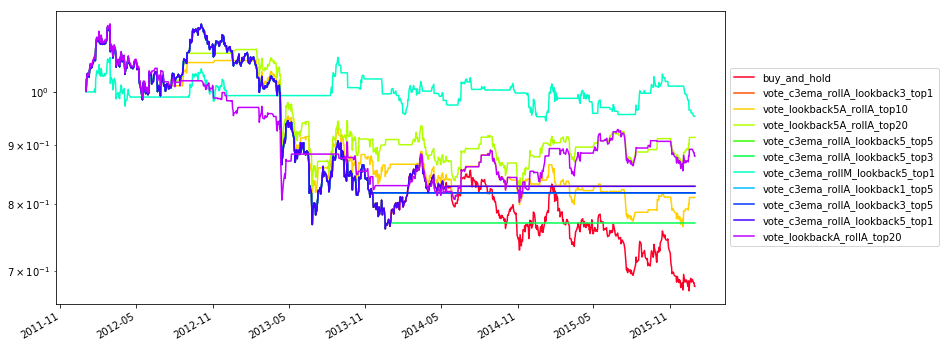

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

,highlight_ratio,flip_ratio,accu,prec,mse
vote_c3ema_rollA_lookback3_top1,0.539347,0.001921,0.510557,0.543298,1.261437
vote_lookback5A_rollA_top10,0.444018,0.149808,0.512476,0.554755,1.215831
vote_lookback5A_rollA_top20,0.390275,0.140845,0.508637,0.557377,1.235230
vote_c3ema_rollA_lookback5_top5,0.638516,0.001921,0.518874,0.543086,1.253660
vote_c3ema_rollA_lookback5_top3,0.638516,0.001921,0.518874,0.543086,1.253660
vote_c3ema_rollM_lookback5_top1,0.649392,0.101793,0.491363,0.521182,1.286003
vote_c3ema_rollA_lookback1_top5,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback3_top5,0.579015,0.001921,0.510557,0.540331,1.259237
vote_c3ema_rollA_lookback5_top1,0.521433,0.026248,0.513116,0.547239,1.251996
vote_lookbackA_rollA_top20,0.384517,0.108835,0.505438,0.554077,1.228728


,annual_return,sharpe_ratio,max_drawdown,avg_drawdown,return/avgdd
buy_and_hold,0.091659,0.718013,-0.185126,-0.066784,1.372467
vote_c3ema_rollA_lookback3_top1,0.032532,0.354775,-0.185126,-0.055088,0.590541
vote_lookback5A_rollA_top10,0.085956,0.965373,-0.143178,-0.038645,2.224212
vote_lookback5A_rollA_top20,0.064012,0.767779,-0.155860,-0.051634,1.239730
vote_c3ema_rollA_lookback5_top5,0.040658,0.415701,-0.185126,-0.053586,0.758738
vote_c3ema_rollA_lookback5_top3,0.040658,0.415701,-0.185126,-0.053586,0.758738
vote_c3ema_rollM_lookback5_top1,0.005214,0.102476,-0.224853,-0.136902,0.038084
vote_c3ema_rollA_lookback1_top5,0.034728,0.369491,-0.185126,-0.052298,0.664044
vote_c3ema_rollA_lookback3_top5,0.034728,0.369491,-0.185126,-0.052298,0.664044
vote_c3ema_rollA_lookback5_top1,0.043544,0.471489,-0.151955,-0.050861,0.856138


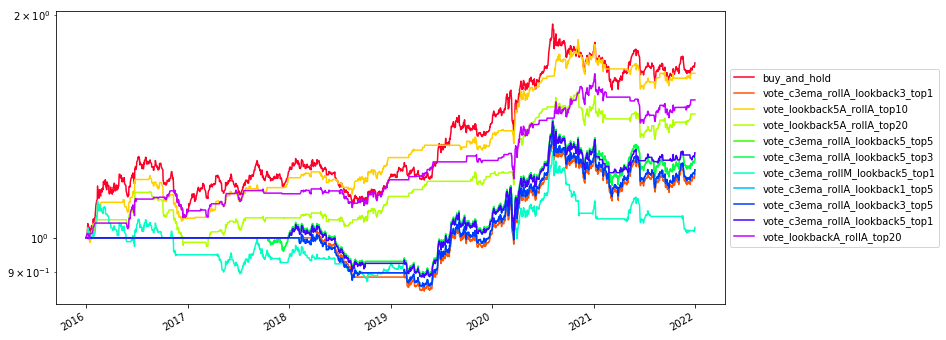

['buy_and_hold',
 'vote_c3ema_rollA_lookback3_top1',
 'vote_lookback5A_rollA_top10',
 'vote_lookback5A_rollA_top20',
 'vote_c3ema_rollA_lookback5_top5',
 'vote_c3ema_rollA_lookback5_top3',
 'vote_c3ema_rollM_lookback5_top1',
 'vote_c3ema_rollA_lookback1_top5',
 'vote_c3ema_rollA_lookback3_top5',
 'vote_c3ema_rollA_lookback5_top1',
 'vote_lookbackA_rollA_top20']

In [100]:
### vote only, sharpe_ratio top10



list_tmp = [i for i in ret_all_sub.columns if ('buy_and_hold' in i) 
            or ('_lookback' in i)
            
           ]

ret_tmp = ret_all_sub[list_tmp]
strategy_list_sel = print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2001':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2016':'2021'], strategy_list_sel=strategy_list_sel)






In [ ]:
"""strategy_list_sel = ['buy_and_hold','vote_c3ema_rollA_top30']

fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""list_tmp = [
    'pp10=xgbc(all_index_(EMA_return_all34+dd_vol))',
    'pp21=xgbc(all_index_(pca(EMA_return_all34+cross_EMA_price_fib34+dd_vol)))',
    'pp21=xgbc(all_index_(EMA_return_all34+dd_vol+excel+excel_cross))',
    'pp10=xgbc(all_index_(pca(EMA_return_all34+up_dd_volm+sd_rsi)))',
    'pp21=xgbc(all_index_(EMA_return_all34+cross_EMA_price_fib34+dd_vol))',
    'pp10=xgbc(all_index_(EMA_return_all34+up_dd_volm))',
    
    
]
pred_top_tmp = pd.concat([pred_all[n] for n in list_tmp], 1, keys=list_tmp).ffill()[start:].fillna(1)
pred_top_tmp.to_csv('pred_top_tmp3.csv')"""

In [ ]:
"""
list_tmp = [
    'vote_c3ema_rollA_lookback3_top5 (no future)',
    
    
]
pred_top_tmp = pd.concat([pred_all_sub[n] for n in list_tmp], 1, keys=list_tmp).ffill()[start:].fillna(1)

pred_top_tmp.columns = ['y_pred']

display(pred_top_tmp)

pred_top_tmp.to_csv('output_others/20220428/pred_vote_c3ema_rollA_lookback3_top5_nofuture.csv')
"""

In [ ]:
"""#strategy_list_sel = ['buy_and_hold','pred_vote_crossema_4xgb','pred_vote_crossema_6xgb']
#strategy_list_sel = ['buy_and_hold','vote_c3ema_roll_top4','vote_c3ema_roll_top6']
strategy_list_sel = ['buy_and_hold','c3ema','vote_c3ema_rollM_top6']
#strategy_list_sel = ['buy_and_hold'] + list(pred_sub.columns)

display(empy_metric_all_sub.loc[strategy_list_sel])



fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")"""

In [ ]:
#set(empy_metric_all_good_sharpe.index) - set(empy_metric_all_good_return.index)

In [ ]:
#set(empy_metric_all_good_return.index) - set(empy_metric_all_good_sharpe.index)

In [ ]:
#empy_metric_all_good_sharpe.to_csv('empy_metric_all_good_sharpe_20220406.csv')

In [ ]:
"""
fig, ax = plt.subplots(figsize=(16,9))


cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all.shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])



(1+ret_all).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
plt.show()
"""

In [ ]:
"""
fig, ax = plt.subplots(figsize=(16,9))

'''
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[['buy_and_hold', 'ema_all_1_34_return___cross_ema_all_1_34_price___10D___sort_feature_prob_cont_2']].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
'''


(1+ret_all[['buy_and_hold', 'ema_all_1_34_return___cross_ema_all_1_34_price___10D___sort_feature_prob_cont_2']]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
plt.show()"""

In [ ]:
"""ret_tmp = ret_all['buy_and_hold']
empy.annual_return(ret_tmp)"""

In [ ]:
"""ret_tmp = ret_all['ema_all_1_34_return___cross_ema_all_1_34_price___5D___sort_feature_prob_cont_5']
empy.annual_return(ret_tmp)"""

In [ ]:
"""ret_tmp = ret_all['ema_all_1_34_return___cross_ema_all_1_34_price___10D___sort_feature_prob_cont_2']
ret_tmp[ret_tmp==0]"""

In [ ]:
"""ret_tmp[ret_tmp == np.nan]"""

In [ ]:
"""# top20
strategy_list_sel = list(empy_metric_all_good_sharpe.index)

strategy_list_sel = strategy_list_sel[-20:]
if 'buy_and_hold' not in strategy_list_sel:
    strategy_list_sel = ['buy_and_hold']+strategy_list_sel


display(other_metric_all_sub.loc[strategy_list_sel[1:]])
display(empy_metric_all_sub.loc[strategy_list_sel])

fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].accu.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].prec.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].mse.plot(ax=ax)
    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""list_tmp = [
    'pp21=xgbc(all_index_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol)))_cont_21_rb_lookback',
    'pp10=xgbc(all_index_(EMA_return_all_1_34+dd_vol))',
    'pp5=xgbc(all_index_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol)))_cont_21_rb_lookback',
    'pp21=xgbc(all_index_(pca(EMA_return_all_1_34+cross_EMA_price_fib_1_34+dd_vol)))_freq_W'
]
pred_top_tmp = pd.concat([pred_all[n] for n in list_tmp], 1, keys=list_tmp).ffill()[start:].fillna(1)
pred_top_tmp.to_csv('pred_top_tmp.csv')"""

In [ ]:
"""strategy_list_sel = ['buy_and_hold',
                     'pred___XAU_USDpp21=EMA_return_all_1_34+cross_EMA_price_all_1_34+dd_vol_freq_M',
                     'pred___XAU_USDpp21=EMA_return_all_1_34+cross_EMA_price_all_1_34+dd_vol_cont_9_rb_lookback']

fig, ax = plt.subplots(figsize=(12,6))
'''
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
'''

(1+ret_all[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")"""

In [ ]:
"""# excelonly

strategy_list_sel = empy_metric_all.index

strategy_list_sel = [x for x in strategy_list_sel if x=='buy_and_hold' or (('freq' not in x) and ('cont' not in x) and ('(excel' in x))]
strategy_list_sel.sort()


empy_metric_tmp = empy_metric_all.loc[strategy_list_sel].sort_values('sharpe_ratio').iloc[-25:]
empy_metric_tmp2 = pd.concat([empy_metric_all.loc[['buy_and_hold']], empy_metric_tmp])


display(other_metric_all.loc[empy_metric_tmp.drop('buy_and_hold').index])
display(empy_metric_tmp2)


    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""# nofreqnocont

strategy_list_sel = empy_metric_all_sub.index

strategy_list_sel = [x for x in strategy_list_sel if (('freq' not in x) and ('cont' not in x))]
strategy_list_sel.sort()


empy_metric_tmp = empy_metric_all_sub.loc[strategy_list_sel].sort_values('sharpe_ratio').iloc[-25:]
#empy_metric_tmp2 = pd.concat([empy_metric_all_sub.loc[['buy_and_hold']], empy_metric_tmp])


display(other_metric_all_sub.loc[empy_metric_tmp.index])
display(empy_metric_tmp)


    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""
list_tmp = [
    'pp10=xgbc(all_index_(EMA_return_all34+dd_vol))',
    'pp21=xgbc(all_index_(EMA_return_all34+dd_vol+excel+excel_cross))',
    'pp21=xgbc(all_index_(pca(EMA_return_all34+cross_EMA_price_fib34+dd_vol)))',
    #'pp21=xgbc(all_index_(pca(EMA_return_all34+cross_EMA_price_fib34+dd_vol+excel+excel_cross)))',
    'pp10=xgbc(all_index_(EMA_return_all34+dd_vol+excel))',
    
]
pred_top_tmp = pd.concat([pred_all_sub[n] for n in list_tmp], 1, keys=list_tmp).ffill()[start:].fillna(1)
pred_top_tmp.to_csv('pred_top_tmp2.csv')
"""

In [ ]:
""" 
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[['buy_and_hold','pred_vote_crossema_4xgb']].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[['buy_and_hold','pred_vote_crossema_4xgb']]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""# freqtop20

strategy_list_sel = empy_metric_all_good_sharpe.index

strategy_list_sel = [x for x in strategy_list_sel if (('freq' in x))]

strategy_list_sel = strategy_list_sel[-20:]
if 'buy_and_hold' not in strategy_list_sel:
    strategy_list_sel = ['buy_and_hold']+strategy_list_sel


display(other_metric_all_sub.loc[strategy_list_sel[1:]])
display(empy_metric_all_sub.loc[strategy_list_sel])

fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].accu.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].prec.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all_sub.loc[strategy_list_sel[1:]].mse.plot(ax=ax)
    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all_sub[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all_sub[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
"""# conttop20

strategy_list_sel = empy_metric_all_good_sharpe.index

strategy_list_sel = [x for x in strategy_list_sel if (('cont' in x))]

strategy_list_sel = strategy_list_sel[-20:]
if 'buy_and_hold' not in strategy_list_sel:
    strategy_list_sel = ['buy_and_hold']+strategy_list_sel


display(other_metric_all.loc[strategy_list_sel[1:]])
display(empy_metric_all.loc[strategy_list_sel])
display(empy_metric_all.loc[strategy_list_sel].iloc[-1])




fig, ax = plt.subplots(figsize=(12,6))
other_metric_all.loc[strategy_list_sel[1:]].accu.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all.loc[strategy_list_sel[1:]].prec.plot(ax=ax)
fig, ax = plt.subplots(figsize=(12,6))
other_metric_all.loc[strategy_list_sel[1:]].mse.plot(ax=ax)
    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[strategy_list_sel].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all[strategy_list_sel]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
"""

In [ ]:
other_metric_all

In [ ]:
strategy_list_vote5tss_all = [i for i in empy_metric_all.index if i=='buy_and_hold' or (
    i.startswith('ema_all_1_34_return___cross_ema_all_1_34_price___5D___') and 
    ('time_series_split' in i or '20220315' in i or 'sort_feature' in i) and
    'set1' in i 
    
)]
     

display(empy_metric_all.loc[strategy_list_vote5tss_all])
display(empy_metric_all.loc[strategy_list_vote5tss_all].mean())


display(other_metric_all.loc[other_metric_all.index.isin(strategy_list_vote5tss_all)])

    
fig, ax = plt.subplots(figsize=(12,6))

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = ret_all[strategy_list_vote5tss_all].shape[1]
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


(1+ret_all[strategy_list_vote5tss_all]).cumprod().plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")


In [ ]:
name_list = []
se_list = []

for name, r in result_all.items():
    #print(name)
    #print(r['empy_metric'])
    #empy_metric_all[name] = r['empy_metric'].iloc[0]
    name_list.append(name)
    se_list.append(r['other_metric'].iloc[0])

    
other_metric_all = pd.concat(se_list, 1, keys=name_list).T
display(other_metric_all.sort_values('accu'))

In [ ]:
scatter_df = pd.concat([empy_metric_all, other_metric_all], 1)



In [ ]:
for yy in ['prec','mse']:
    fig, ax = plt.subplots()
    sns.regplot(data=scatter_df, x="accu", y=yy, ax=ax)


In [ ]:
for yy in ['annual_return','sharpe_ratio']:
    for xx in ['accu','prec','mse']:
    
        fig, ax = plt.subplots()
        sns.regplot(data=scatter_df, x=xx, y=yy, ax=ax)


In [ ]:
"""for yy in ['annual_return','sharpe_ratio']:
    for xx in ['accu5','prec5','mse5']:
        
        fig, ax = plt.subplots()
        sns.regplot(data=scatter_df, x=xx, y=yy, ax=ax)
"""

In [ ]:
"""for yy in ['annual_return','sharpe_ratio']:
    for xx in ['accu10','prec10','mse10']:
    
        fig, ax = plt.subplots()
        sns.regplot(data=scatter_df, x=xx, y=yy, ax=ax)
"""

In [ ]:
"""for yy in ['annual_return','sharpe_ratio']:
    for xx in ['accu21','prec21','mse21']:
    
        fig, ax = plt.subplots()
        sns.regplot(data=scatter_df, x=xx, y=yy, ax=ax)
"""

In [ ]:
annual_return_all = pd.concat([v['empy_metric'].annual_return for v in result_all.values()]).sort_values()

annual_return_all.plot()
annual_return_all.tail(20)


In [ ]:
sharpe_ratio_all = pd.concat([v['empy_metric'].sharpe_ratio for v in result_all.values()]).sort_values()

sharpe_ratio_all.plot()
sharpe_ratio_all.tail(20)

In [ ]:
(ret/ret.std()).plot.density()

In [ ]:
(ret/ret.std()).sort_values().head(10)

In [ ]:
(ret/ret.std()).sort_values().tail(10)

In [ ]:
true_up_pct_scaled = ret/ret.std() + 0.5


In [ ]:
pred_up_all_correct = (ret>=0)*1
mse_all_correct = mean_squared_error(true_up_pct_scaled, pred_up_all_correct)
mse_all_correct

In [ ]:
pred_up_all_wrong = (ret<0)*1
mse_all_wrong = mean_squared_error(true_up_pct_scaled, pred_up_all_wrong)
mse_all_wrong

In [ ]:
pred_up_all_half = ret*0
mse_all_half = mean_squared_error(true_up_pct_scaled, pred_up_all_half)
mse_all_half

In [ ]:
pred_up_all_half = ret*0+0.5
mse_all_half = mean_squared_error(true_up_pct_scaled, pred_up_all_half)
mse_all_half

In [ ]:
pred_up_all_half = ret*0+1
mse_all_half = mean_squared_error(true_up_pct_scaled, pred_up_all_half)
mse_all_half

In [ ]:
temp_df = pd.DataFrame(prob_all)[start:end]
#temp_df = temp_df[[i for i in strategy_list_vote5tss if i in temp_df.columns]]
#print_clustermap(temp_df)
#temp_df.plot.density()

In [ ]:
temp_df.applymap(lambda x: 0 if x<0.5 else 1).plot()

In [ ]:
temp_df.applymap(lambda x: 0 if x<0.5 else 1).groupby(pd.Grouper(freq='M')).first().plot()

In [ ]:
temp_df.plot()

In [ ]:
temp_df.min()

In [ ]:
temp_df.max()

In [ ]:
'''temp_df = pd.DataFrame(pred_all)[start:end]
temp_df = temp_df[[i for i in strategy_list_5fc if i in temp_df.columns]]
print_clustermap(temp_df)'''

In [ ]:
'''temp_df = pd.DataFrame(pred_all)[start:end]
temp_df = temp_df[[i for i in strategy_list_vote5sf if i in temp_df.columns]]
temp_df'''

In [ ]:
temp_df.plot()

In [ ]:
temp_df = pd.DataFrame(pred_all)[start:end]
pp21_list = [i for i in temp_df.columns if '___21D___' in i]
temp_df = temp_df.loc[:,temp_df.columns.isin(pp21_list)]
temp_df

In [ ]:
temp_df.columns

In [ ]:
#temp_df.to_csv('pred_xauusd_pp21.csv')